In [ ]:
!git clone https://github.com/bamsumit/slayerPytorch
!pip install ninja
!pip install dv
exit()

^C


Cloning into 'slayerPytorch'...
Updating files:  21% (310/1435)
Updating files:  22% (316/1435)
Updating files:  23% (331/1435)
Updating files:  24% (345/1435)
Updating files:  25% (359/1435)
Updating files:  26% (374/1435)
Updating files:  27% (388/1435)
Updating files:  28% (402/1435)
Updating files:  29% (417/1435)
Updating files:  30% (431/1435)
Updating files:  31% (445/1435)
Updating files:  32% (460/1435)
Updating files:  33% (474/1435)
Updating files:  34% (488/1435)
Updating files:  35% (503/1435)
Updating files:  36% (517/1435)
Updating files:  37% (531/1435)
Updating files:  38% (546/1435)
Updating files:  39% (560/1435)
Updating files:  40% (574/1435)
Updating files:  41% (589/1435)
Updating files:  42% (603/1435)
Updating files:  43% (618/1435)
Updating files:  44% (632/1435)
Updating files:  45% (646/1435)
Updating files:  46% (661/1435)
Updating files:  47% (675/1435)
Updating files:  48% (689/1435)
Updating files:  49% (704/1435)
Updating files:  50% (718/1435)
Updating

In [1]:
%cd slayerPytorch/
!python setup.py install
exit()

D:\home\NMNISTAttacks\slayerPytorch
running install
running bdist_egg
running egg_info
creating slayerCuda.egg-info
writing slayerCuda.egg-info\PKG-INFO
writing dependency_links to slayerCuda.egg-info\dependency_links.txt
writing top-level names to slayerCuda.egg-info\top_level.txt
writing manifest file 'slayerCuda.egg-info\SOURCES.txt'
reading manifest file 'slayerCuda.egg-info\SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'slayerCuda.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_ext
building 'slayerCuda' extension
creating D:\home\NMNISTAttacks\slayerPytorch\build\temp.win-amd64-cpython-310\Release\src\cuda
[1/1] C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.4\bin\nvcc --generate-dependencies-with-compile --dependency-output D:\home\NMNISTAttacks\slayerPytorch\build\temp.win-amd64-cpython-310\Release\src\cuda\slayerKernels.obj.d -std=c++17 --use-local-env -Xcompiler /MD -Xcompiler /wd4819 -Xcom

D:\anaconda\envs\seong\lib\site-packages\setuptools\_distutils\cmd.py:90: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
D:\anaconda\envs\seong\lib\site-packages\setuptools\_distutils\cmd.py:90: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/

In [4]:
%cd slayerPytorch/test/
!python -m  unittest

D:\home\NMNISTAttacks\slayerPytorch\slayerPytorch\test
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


.................................
----------------------------------------------------------------------
Ran 33 tests in 38.029s

OK


In [1]:
import numpy as np

data = np.load("/home/NMNISTAttacks/slayerPytorch/N-MNIST/Test_npy_fin/1.npy")
print(data.shape)  # (nEvents, 4)

(4840, 4)


In [2]:
%cd /home/NMNISTAttacks/slayerPytorch

D:\home\NMNISTAttacks\slayerPytorch


In [4]:
# 아마 이 코드부터가 원본 코드인듯(최대한 실행가능하게 수정해놓음)
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append("/home/NMNISTAttacks/slayerPytorch/src")

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
from learningStats import learningStats
import zipfile

# Dataset definition
class nmnistDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]
        
        inputSpikes = snn.io.read2Dspikes(
                        self.path + str(inputIndex.item()) + '.bs2'
                        ).toSpikeTensor(torch.zeros((2,34,34,self.nTimeBins)),
                        samplingTime=self.samplingTime)
        desiredClass = torch.zeros((10, 1, 1, 1))
        desiredClass[classLabel,...] = 1
        return inputSpikes, desiredClass, classLabel
    
    def __len__(self):
        return self.samples.shape[0]

# Network definition
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        self.conv1 = slayer.conv(2, 16, 5, padding=1)
        self.conv2 = slayer.conv(16, 32, 3, padding=1)
        self.conv3 = slayer.conv(32, 64, 3, padding=1)
        self.pool1 = slayer.pool(2)
        self.pool2 = slayer.pool(2)
        self.fc1   = slayer.dense((8, 8, 64), 10)

    def forward(self, spikeInput):
        spikeLayer1 = self.slayer.spike(self.conv1(self.slayer.psp(spikeInput ))) # 32, 32, 16
        spikeLayer2 = self.slayer.spike(self.pool1(self.slayer.psp(spikeLayer1))) # 16, 16, 16
        spikeLayer3 = self.slayer.spike(self.conv2(self.slayer.psp(spikeLayer2))) # 16, 16, 32
        spikeLayer4 = self.slayer.spike(self.pool2(self.slayer.psp(spikeLayer3))) #  8,  8, 32
        spikeLayer5 = self.slayer.spike(self.conv3(self.slayer.psp(spikeLayer4))) #  8,  8, 64
        spikeOut    = self.slayer.spike(self.fc1  (self.slayer.psp(spikeLayer5))) #  10

        return spikeOut

In [5]:
import time
import shutil

def save_ckp(state, is_best_loss, is_best_acc, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir+'checkpoint.pt'
    torch.save(state, f_path)
    if is_best_loss:
        best_fpath = best_model_dir+'best_model.pt'
        shutil.copyfile(f_path, best_fpath)
    if is_best_acc:
        acc_fpath =  best_model_dir+'best_acc.pt'
        shutil.copyfile(f_path, acc_fpath)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']


# Read SNN configuration from yaml file
netParams = snn.params('/home/NMNISTAttacks/slayerPytorch/exampleLoihi/02_NMNIST/network.yaml')

# Ts   = netParams['simulation']['Ts']
# Ns   = int(netParams['simulation']['tSample'] / netParams['simulation']['Ts'])
# Nin  = int(netParams['layer'][0]['dim'])
# Nhid = int(netParams['layer'][1]['dim'])
# Nout = int(netParams['layer'][2]['dim'])

# Extract NMNISTsmall dataset
with zipfile.ZipFile('/home/NMNISTAttacks/slayerPytorch/exampleLoihi/02_NMNIST/NMNISTsmall.zip') as zip_file:
    for member in zip_file.namelist():
        if not os.path.exists('./' + member):
            zip_file.extract(member, './')

In [5]:
if __name__ == '__main__':
    
    # Define the cuda device to run the code on.
    device = torch.device('cuda')
    # Use multiple GPU's if available
    # device = torch.device('cuda:2') # should be the first GPU of deviceIDs
    # deviceIds = [2, 3, 1]

    # Create network instance.
    net = Network(netParams).to(device)
    # Split the network to run over multiple GPUs
    # net = torch.nn.DataParallel(Network(netParams).to(device), device_ids=deviceIds)

    # Create snn loss instance.
    error = snn.loss(netParams, slayerClass=snn.loihi).to(device)

    # Define optimizer module.
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

    # Dataset and dataLoader instances.
    trainingSet = nmnistDataset(datasetPath =netParams['training']['path']['in'], 
                                sampleFile  =netParams['training']['path']['train'],
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
    trainLoader = DataLoader(dataset=trainingSet, batch_size=12, shuffle=False, num_workers=4)

    testingSet = nmnistDataset(datasetPath  =netParams['training']['path']['in'], 
                                sampleFile  =netParams['training']['path']['test'],
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
    testLoader = DataLoader(dataset=testingSet, batch_size=12, shuffle=False, num_workers=4)

    # Learning stats instance.
    stats = learningStats()

    # training loop
    for epoch in range(100):
        tSt = datetime.now()
        
        # Training loop.
        for i, (input, target, label) in enumerate(trainLoader, 0):
            net.train()
            
            # Move the input and target to correct GPU.
            input  = input.to(device)
            target = target.to(device) 
            
            # Forward pass of the network.
            output = net.forward(input)
            
            # Gather the training stats.
            stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
            stats.training.numSamples     += len(label)
            
            # Calculate loss.
            loss = error.numSpikes(output, target)
            
            # Reset gradients to zero.
            optimizer.zero_grad()
            
            # Backward pass of the network.
            loss.backward()
            
            # Update weights.
            optimizer.step()

            # Gather training loss stats.
            stats.training.lossSum += loss.cpu().data.item()

            # Display training stats.
            stats.print(epoch, i, (datetime.now() - tSt).total_seconds())

        # Testing loop.
        # Same steps as Training loops except loss backpropagation and weight update.
        for i, (input, target, label) in enumerate(testLoader, 0):
            net.eval()

            with torch.no_grad():
                input  = input.to(device)
                target = target.to(device)
            output = net.forward(input)
            stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
            stats.testing.numSamples     += len(label)
            loss = error.numSpikes(output, target)
            stats.testing.lossSum += loss.cpu().data.item()
        stats.print(epoch, i)
        # Update stats.
        stats.update()
        checkpoint={
                          'epoch': epoch+1,
                          'state_dict':net.state_dict(),
                          'optimizer': optimizer.state_dict()}
        save_ckp(checkpoint,stats.training.bestLoss, stats.testing.bestAccuracy,'./', './')

Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi

Epoch :          0(i =       0),     364.4320 ms elapsed
loss = 4.2626e+05                         accuracy = 0.083333                 

Epoch :          0(i =       1),     705.8240 ms elapsed
loss = 4.1117e+05                         accuracy = 0.083333                 

Epoch :          0(i =       2),     960.4510 ms elapsed
loss = 4.3923e+05                         accuracy = 0.11111                  

Epoch :          0(i =       3),    1304.8850 ms elapsed
loss = 3.881e+05                          accuracy = 0.125                    

Epoch :          0(i =       4),    1625.9570 ms elapsed
loss = 3.5775e+05                         accuracy = 0.15                     

Epoch :          0(i =       5),    1973.0690 ms elapsed
loss = 3.4173e+05                         accuracy = 0.15278                  

Epoch :          0(i 

KeyboardInterrupt: 

In [4]:
# bin 파일 npy 파일로 변환

import os
import numpy as np
import slayerSNN as snn
from tqdm import tqdm # 진행 상황을 보기 위해 tqdm import

def readBinEvent(filename):
    """
    .bin 파일을 읽어 x, y, p, t 배열로 반환하는 함수
    (DVSGesture 형식(x,y,p,t)으로 저장)
    """
    try:
        evtStream = np.fromfile(filename, dtype=np.uint8)
        xEvent = evtStream[0::5] + 1  # X 좌표
        yEvent = evtStream[1::5] + 1  # Y 좌표
        pEvent = (evtStream[2::5] >> 7) + 1  # Polarity (1=OFF, 2=ON)
        tEvent = ((evtStream[2::5] & 127) << 16) + (evtStream[3::5] << 8) + evtStream[4::5]
        return xEvent, yEvent, pEvent, tEvent
    except Exception as e:
        print(f"\n파일 읽기 오류 ({filename}): {e}")
        return None, None, None, None

def save_to_npy(bin_filename, npy_filename):
    """
    .bin 파일을 읽어 .npy 파일로 저장하는 함수
    """
    x, y, p, t = readBinEvent(bin_filename)
    if x is None: # 파일 읽기 실패 시
        return False
        
    events = np.column_stack((x, y, p, t))
    np.save(npy_filename, events) # 2D array로 저장
    return True

# --- 1. 경로 설정 ---
base_path_train = '/home/NMNISTAttacks/slayerPytorch/N-MNIST/Train/'
base_path_test = '/home/NMNISTAttacks/slayerPytorch/N-MNIST/Test/'
output_folder_train = '/home/NMNISTAttacks/slayerPytorch/N-MNIST/Train_npy/'
output_folder_test = '/home/NMNISTAttacks/slayerPytorch/N-MNIST/Test_npy/'

# --- 2. Train 데이터 변환 ---
if os.path.exists(output_folder_train):
    print(f"'{output_folder_train}' 폴더가 이미 존재하므로, Train 데이터 변환을 건너뜁니다.")
else:
    os.makedirs(output_folder_train)
    print(f"'{output_folder_train}' 폴더를 생성했습니다.")

    output_txt_train = os.path.join(output_folder_train, 'train.txt')
    with open(output_txt_train, 'w') as f_train:
        global_file_counter = 0
        for i in tqdm(range(10), desc="Train 클래스 처리 중"): # 0~9 클래스
            class_path = os.path.join(base_path_train, str(i))
            for j in range(60000): # 00000 ~ 59999
                num = format(j, '05')
                bin_file_path = os.path.join(class_path, f'{num}.bin')
                
                if not os.path.isfile(bin_file_path):
                    continue
                    
                npy_file_path = os.path.join(output_folder_train, f'{global_file_counter}.npy')
                
                if save_to_npy(bin_file_path, npy_file_path):
                    f_train.write(f'{global_file_counter} {i}\n')
                    global_file_counter += 1
    print(f"Train 데이터 변환 완료. 총 {global_file_counter}개 파일 생성.")

# --- 3. Test 데이터 변환 ---
if os.path.exists(output_folder_test):
    print(f"'{output_folder_test}' 폴더가 이미 존재하므로, Test 데이터 변환을 건너뜁니다.")
else:
    os.makedirs(output_folder_test)
    print(f"'{output_folder_test}' 폴더를 생성했습니다.")

    output_txt_test = os.path.join(output_folder_test, 'test.txt')
    with open(output_txt_test, 'w') as f_test:
        global_file_counter = 0 # 테스트 파일 카운터 리셋
        for i in tqdm(range(10), desc="Test 클래스 처리 중"): # 0~9 클래스
            class_path = os.path.join(base_path_test, str(i))
            for j in range(10000): # 00000 ~ 09999
                num = format(j, '05')
                bin_file_path = os.path.join(class_path, f'{num}.bin')
                
                if not os.path.isfile(bin_file_path):
                    continue
                
                npy_file_path = os.path.join(output_folder_test, f'{global_file_counter}.npy')
                
                if save_to_npy(bin_file_path, npy_file_path):
                    f_test.write(f'{global_file_counter} {i}\n')
                    global_file_counter += 1
    print(f"Test 데이터 변환 완료. 총 {global_file_counter}개 파일 생성.")

'/home/NMNISTAttacks/slayerPytorch/N-MNIST/Train_npy/' 폴더를 생성했습니다.


Train 클래스 처리 중: 100%|████████████████████████████████████████████████████████████| 10/10 [11:45<00:00, 70.59s/it]

Train 데이터 변환 완료. 총 59999개 파일 생성.
'/home/NMNISTAttacks/slayerPytorch/N-MNIST/Test_npy/' 폴더가 이미 존재하므로, Test 데이터 변환을 건너뜁니다.


In [5]:
# txt 파일 이름 순 정렬 안하면 정확도 이상해짐(정렬 코드)
def sort_txt_by_filename(txt_file):
    # 파일 읽기
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    
    # 데이터 파싱 (이름: 첫 번째 열, 레이블: 두 번째 열)
    data = [line.strip().split() for line in lines]

    # 정렬 (이름순 정렬 → 첫 번째 컬럼 기준, 숫자로 변환하여 정렬)
    data.sort(key=lambda x: int(x[0]))

    # 정렬된 데이터를 다시 파일에 저장
    with open(txt_file, 'w') as f:
        for entry in data:
            f.write(f"{entry[0]} {entry[1]}\n")

    print(f"파일 정렬 완료: {txt_file}")

# 사용 예시
sort_txt_by_filename("/home/NMNISTAttacks/slayerPytorch/N-MNIST/Train_npy/train.txt")
sort_txt_by_filename("/home/NMNISTAttacks/slayerPytorch/N-MNIST/Test_npy/test.txt")

파일 정렬 완료: /home/NMNISTAttacks/slayerPytorch/N-MNIST/Train_npy/train.txt
파일 정렬 완료: /home/NMNISTAttacks/slayerPytorch/N-MNIST/Test_npy/test.txt


In [6]:
import numpy as np
import os
from tqdm import tqdm # 진행 상황을 보기 위해 tqdm 추가

# 데이터셋 경로 설정
train_data_dir = "/home/NMNISTAttacks/slayerPytorch/N-MNIST/Train_npy/"

print(f"'{train_data_dir}' 폴더의 파일 좌표 수정을 시작합니다...")

# 파일 범위 설정 (0.npy ~ 59998.npy)
# tqdm을 사용해 진행률 표시
for i in tqdm(range(59999), desc="파일 처리 진행률"):
    file_path = os.path.join(train_data_dir, f"{i}.npy")

    # 파일 존재 여부 확인
    if os.path.isfile(file_path):
        try:
            data = np.load(file_path, mmap_mode='r+')
            
            # x, y 좌표 -1 적용
            data[:, 0] -= 1
            data[:, 1] -= 1
            
            del data 

        except ValueError:
            tqdm.write(f"[ERROR] 파일 처리 중 오류 발생: {file_path}")
            continue
        except Exception as e:
            tqdm.write(f"[ERROR] 알 수 없는 오류 ({file_path}): {e}")
            continue

print("[✅] All training files processed successfully!")

'/home/NMNISTAttacks/slayerPytorch/N-MNIST/Train_npy/' 폴더의 파일 좌표 수정을 시작합니다...


파일 처리 진행률: 100%|█████████████████████████████████████████████████████████| 59999/59999 [08:01<00:00, 124.52it/s]

[✅] All training files processed successfully!


In [7]:
import numpy as np
import os
from tqdm import tqdm # 진행 상황을 보기 위해 tqdm 추가

# ---👇 [핵심 수정] ---
# 데이터셋 경로를 'Test_npy' 폴더로 변경합니다.
test_data_dir = "/home/NMNISTAttacks/slayerPytorch/N-MNIST/Test_npy/"

print(f"'{test_data_dir}' 폴더의 파일 좌표 수정을 시작합니다...")

# 파일 범위를 테스트 데이터셋 크기인 10000개로 변경합니다. (0.npy ~ 9999.npy)
for i in tqdm(range(10000), desc="파일 처리 진행률"):
    file_path = os.path.join(test_data_dir, f"{i}.npy")

    # 파일 존재 여부 확인
    if os.path.isfile(file_path):
        try:
            data = np.load(file_path, mmap_mode='r+')
            
            # x, y 좌표 -1 적용
            data[:, 0] -= 1
            data[:, 1] -= 1
            
            del data 

        except ValueError:
            tqdm.write(f"[ERROR] 파일 처리 중 오류 발생: {file_path}")
            continue
        except Exception as e:
            tqdm.write(f"[ERROR] 알 수 없는 오류 ({file_path}): {e}")
            continue

# ---👇 [핵심 수정] ---
print("[✅] All test files processed successfully!")

'/home/NMNISTAttacks/slayerPytorch/N-MNIST/Test_npy/' 폴더의 파일 좌표 수정을 시작합니다...


파일 처리 진행률: 100%|██████████████████████████████████████████████████████████| 10000/10000 [01:58<00:00, 84.66it/s]

[✅] All test files processed successfully!


In [3]:
%cd /home/NMNISTAttacks/slayerPytorch/N-MNIST

D:\home\NMNISTAttacks\slayerPytorch\N-MNIST


In [4]:
# NMNIST 코드 Loihi 코드로 바꿈(일단 Attack쪽 네트워크로)
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append("/home/NMNISTAttacks/slayerPytorch/src")

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
import zipfile
import shutil

# Read SNN configuration from yaml file
netParams = snn.params('/home/NMNISTAttacks/slayerPytorch/exampleLoihi/02_NMNIST/network.yaml')

# Ts   = netParams['simulation']['Ts']
# Ns   = int(netParams['simulation']['tSample'] / netParams['simulation']['Ts'])
# Nin  = int(netParams['layer'][0]['dim'])
# Nhid = int(netParams['layer'][1]['dim'])
# Nout = int(netParams['layer'][2]['dim'])

# Dataset definition
class nmnistDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]
        
        fileName = self.path + str(inputIndex.item()) + '.npy'

        try:
            check_data = np.load(fileName)
        except:
            check_data = np.empty((0, 4))

        if check_data.size == 0:
            inputSpikes = torch.zeros((2, 34, 34, self.nTimeBins))
        else:
            inputSpikes = snn.io.readNpSpikes(
                        fileName
                        ).toSpikeTensor(torch.zeros((2,34,34,self.nTimeBins)),
                        samplingTime=self.samplingTime)
            
        # 실험 수정 파트
        inputSpikes = inputSpikes.view(2 * 34 * 34, 1, 1, self.nTimeBins)
        desiredClass = torch.zeros((10, 1, 1, 1))
        desiredClass[classLabel,...] = 1
        return inputSpikes, desiredClass, classLabel
    
    def __len__(self):
        return self.samples.shape[0]

# Network definition
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = snn.slayerLoihi.spikeLayer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        
        # define network functions
        self.fc1 = slayer.dense((34*34*2), 512)
        self.fc2   = slayer.dense(512, 10)
        
    def forward(self, spikeInput):
        spike = self.slayer.spikeLoihi(self.fc1(spikeInput))
        spike = self.slayer.delayShift(spike, 1)
        # A minimum axonal delay of 1 tick is required in Loihi hardare
        spike = self.slayer.spikeLoihi(self.fc2(spike))
        spike = self.slayer.delayShift(spike, 1)
        
        return spike


def save_ckp(state, is_best_loss, is_best_acc, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir+'checkpoint.pt'
    torch.save(state, f_path)
    if is_best_loss:
        best_fpath = best_model_dir+'best_model.pt'
        shutil.copyfile(f_path, best_fpath)
    if is_best_acc:
        acc_fpath =  best_model_dir+'best_acc.pt'
        shutil.copyfile(f_path, acc_fpath)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

if __name__ == '__main__':
    # Define the cuda device to run the code on.
    device = torch.device('cuda')

    # Create network instance.
    net = Network(netParams).to(device)

    # Create snn loss instance.
    error = snn.loss(netParams, snn.loihi).to(device)

    # Define optimizer module.
    optimizer = snn.utils.optim.Nadam(net.parameters(), lr = 0.01, amsgrad = True)

    # Learning stats instance.
    stats = snn.utils.stats()

    # Dataset and dataLoader instances.
    trainingSet = nmnistDataset(datasetPath ='Train_npy_fin/', 
                                sampleFile  ='Train_npy_fin/train.txt',
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
    trainLoader = DataLoader(dataset=trainingSet, batch_size=12, shuffle=False, num_workers=0)

    testingSet = nmnistDataset(datasetPath ='Test_npy_fin/', 
                                sampleFile  ='Test_npy_fin/test.txt',
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
    testLoader = DataLoader(dataset=testingSet, batch_size=12, shuffle=False, num_workers=0)



Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


In [5]:
# model load
net, optimizer, start_epoch = load_ckp('/home/NMNISTAttacks/slayerPytorch/checkpoint.pt', net, optimizer)

C:\Users\dhtjd\AppData\Local\Temp\ipykernel_10780\262074053.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)


In [8]:
# training loop
for epoch in range(100):
    tSt = datetime.now()

    net.train()
    
    # Training loop.
    for i, (input, target, label) in enumerate(trainLoader, 0):
        
        # Move the input and target to correct GPU.
        input  = input.to(device)
        target = target.to(device) 
        # label = label.to(device)
            
        # Forward pass of the network.
        output = net.forward(input)
            
        # Gather the training stats.
        stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).item()
        stats.training.numSamples     += len(label)
            
        # Calculate loss.
        loss = error.numSpikes(output, target)
            
        # Backward pass of the network.
        loss.backward()
            
        # Update weights.
        optimizer.step()

        # Reset gradients to zero.
        optimizer.zero_grad()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Display training stats.
        #stats.print(epoch, i, (datetime.now() - tSt).total_seconds())

    stats.print(epoch, 4999, (datetime.now() - tSt).total_seconds())
    
    net.eval()
    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, (input, target, label) in enumerate(testLoader, 0):
        with torch.no_grad():
            input  = input.to(device)
            target = target.to(device)
        output = net.forward(input)
        stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.testing.numSamples     += len(label)
        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
    stats.print(epoch, 833)
    # Update stats.
    stats.update()
    checkpoint={
                'epoch': epoch+1,
                'state_dict':net.state_dict(),
                'optimizer': optimizer.state_dict()}
    save_ckp(checkpoint,stats.training.bestLoss, stats.testing.bestAccuracy,'./', './')

/home/jupyter-jsw/.local/lib/python3.10/site-packages/slayerSNN-0.0.0-py3.10.egg/slayerSNN/optimizer.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/torch/csrc/utils/python_arg_parser.cpp:1519.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)



Epoch :          0(i =    4999),  336547.6230 ms elapsed
loss = 1.1168                             accuracy = 0.90473                  

Epoch :          0(i =     833)
loss = 1.1168                             accuracy = 0.90473                  
loss = 1.0903                             accuracy = 0.90259                  

Epoch :          1(i =    4999),  336493.9790 ms elapsed
loss = 0.76753     (min = 1.1168     )    accuracy = 0.94545  (max = 0.90473 )

Epoch :          1(i =     833)
loss = 0.76753     (min = 1.1168     )    accuracy = 0.94545  (max = 0.90473 )
loss = 0.9457      (min = 1.0903     )    accuracy = 0.91979  (max = 0.90259 )

Epoch :          2(i =    4999),  335694.3010 ms elapsed
loss = 0.67569     (min = 0.76753    )    accuracy = 0.95622  (max = 0.94545 )

Epoch :          2(i =     833)
loss = 0.67569     (min = 0.76753    )    accuracy = 0.95622  (max = 0.94545 )
loss = 0.90393     (min = 0.9457     )    accuracy = 0.92659  (max = 0.91979 )

Epoch :        

In [6]:
# 모델 테스트
testingSet = nmnistDataset(datasetPath ='Test_npy/', 
                                sampleFile  ='Test_npy/test.txt',
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=40, shuffle=False, num_workers=0)

for epoch in range(1):
    stats.testing.reset()
    tSt = datetime.now()
    net.eval()
    # Testing loop.
    for i, (input, target, label) in enumerate(testLoader, 0):
      with torch.no_grad():
        input  = input.to(device)
        target = target.to(device) 
    
      output = net.forward(input)
      stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
      stats.testing.numSamples     += len(label)

      loss = error.numSpikes(output, target)
      stats.testing.lossSum += loss.cpu().data.item()
      stats.print(epoch, i)


Epoch :          0(i =       0)
None
loss = 1.0087                             accuracy = 0.975                    

Epoch :          0(i =       1)
None
loss = 1.2744                             accuracy = 0.925                    

Epoch :          0(i =       2)
None
loss = 1.2827                             accuracy = 0.925                    

Epoch :          0(i =       3)
None
loss = 1.2677                             accuracy = 0.91875                  

Epoch :          0(i =       4)
None
loss = 1.3128                             accuracy = 0.91                     

Epoch :          0(i =       5)
None
loss = 1.3206                             accuracy = 0.91667                  

Epoch :          0(i =       6)
None
loss = 1.3132                             accuracy = 0.925                    

Epoch :          0(i =       7)
None
loss = 1.3044                             accuracy = 0.92812                  

Epoch :          0(i =       8)
None
loss = 1.2602             

In [20]:
from IPython.display import HTML

testingSet = nmnistDataset(datasetPath ='Test_npy_fin/',
                                sampleFile  ='Test_npy_fin/test.txt',
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=40, shuffle=False, num_workers=0)

i = 0
input, target, label = testingSet[i]
print(label)
#snn.io.showTD(snn.io.spikeArrayToEvent(input.reshape((2, 128, 128, -1)).cpu().data.numpy()))
anim = snn.io.animTD(snn.io.spikeArrayToEvent(input.reshape((2, 34, 34, -1)).cpu().data.numpy()))
HTML(anim.to_jshtml())

7



Epoch :          0(i =       0)
None
loss = 1.0197                             accuracy = 1                        

Epoch :          0(i =       1)
None
loss = 1.5041                             accuracy = 0.95                     

Epoch :          0(i =       2)
None
loss = 1.3072                             accuracy = 0.94167                  

Epoch :          0(i =       3)
None
loss = 1.5201                             accuracy = 0.93125                  

Epoch :          0(i =       4)
None
loss = 1.4077                             accuracy = 0.935                    

Epoch :          0(i =       5)
None
loss = 1.3134                             accuracy = 0.94167                  

Epoch :          0(i =       6)
None
loss = 1.3355                             accuracy = 0.93571                  

Epoch :          0(i =       7)
None
loss = 1.3565                             accuracy = 0.9375                   

Epoch :          0(i =       8)
None
loss = 1.6145             

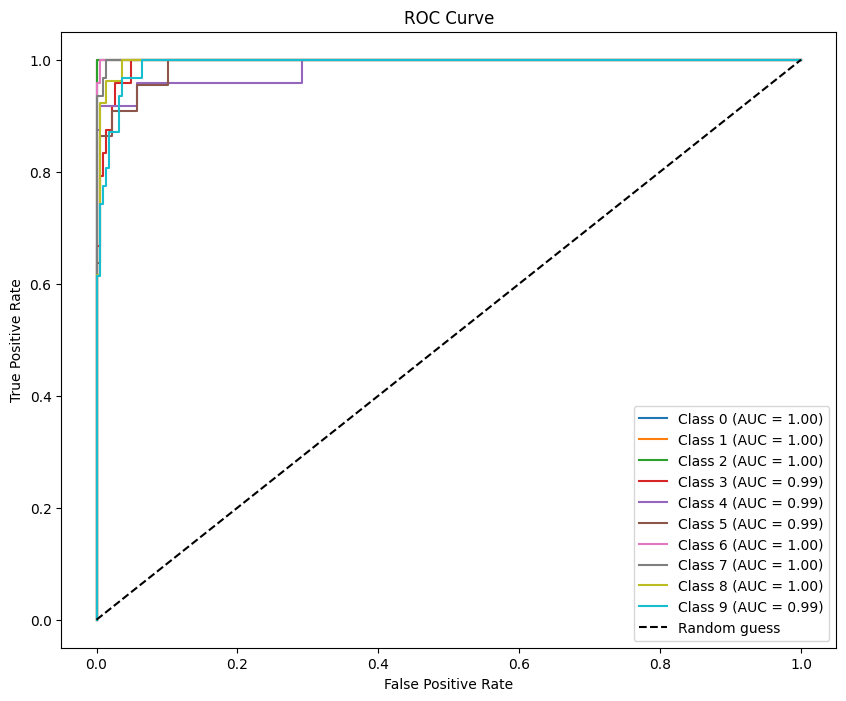

In [21]:
# 모델 테스트 지표 더 많이(기존 급격한 커브 그림)
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, f1_score,auc
from sklearn.preprocessing import label_binarize, MinMaxScaler

testingSet = nmnistDataset(datasetPath ='dashattack_cluster_window5_5_100_fin_IQR/', 
                                sampleFile  ='Test_npy_fin/test.txt',
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=40, shuffle=False, num_workers=0)

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # 수치 안정성
    return exp_x / exp_x.sum()

def softmax_for_samples(scores):
    return np.array([softmax(sample) for sample in scores])

for epoch in range(1):
    stats.testing.reset()
    tSt = datetime.now()
    net.eval()

    y_true = []
    y_pred = []
    y_test = []
    y_score = []
    
    # Testing loop.
    for i, (input, target, label) in enumerate(testLoader, 0):
        with torch.no_grad():
            input  = input.to(device)
            target = target.to(device) 
        
        y_true.append(label)
        
        output = net.forward(input)

        # 실험용 부분
        y_test.append(label.tolist()[0])
        numSpikes = torch.sum(output, 4, keepdim=True).cpu()
        y_score.append(numSpikes.reshape(numSpikes.shape[0], -1)[0].tolist())
        predict = snn.predict.getClass(output)
        y_pred.append(predict)
        
        stats.testing.correctSamples += torch.sum( predict == label ).data.item()
        stats.testing.numSamples     += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        stats.print(epoch, i)

    # Tensor를 numpy array로 변환 후 1D 배열로 펼치기
    y_true = torch.cat(y_true).cpu().numpy().flatten()
    y_pred = torch.cat(y_pred).cpu().numpy().flatten()

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print('precision: {0:.4f}, recall: {1:.4f}, f1: {2:.4f}'.format(precision, recall, f1))
    
    # ROC_Curve
    y_test = np.array(y_test)
    y_test = label_binarize(y_test, classes=np.arange(11))
    y_score = softmax_for_samples(np.array(y_score))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # ROC 곡선 시각화
    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

In [20]:
# BAF

import numpy as np
import os
import torch
from torch.utils.data import DataLoader

# (필요한 라이브러리 import가 되어 있다고 가정합니다. 
# 예: snn, nmnistDataset, net, device 등은 사용자의 환경에 맞게 정의되어 있어야 합니다.)

def update(x, y, t, A, s):
    for i in range(x - s, x + s + 1):
        for j in range(y - s, y + s + 1):
            if not (i == x and j == y) and i >= 0 and j >= 0 and i < 34 and j < 34:
                A[i][j] = t

# 데이터셋 설정
testSet = nmnistDataset(datasetPath='/home/NMNISTAttacks/slayerPytorch/N-MNIST/dashattack/', 
                        sampleFile='/home/NMNISTAttacks/slayerPytorch/N-MNIST/dashattack/test.txt',
                        samplingTime=1.0,
                        sampleLength=350)
testLoader = DataLoader(dataset=testSet, batch_size=1, shuffle=False, num_workers=4)

# 루프 시작
for s in [1, 2, 3]:
    stats1 = snn.utils.stats()
    stats5 = snn.utils.stats()
    stats10 = snn.utils.stats()
    stats20 = snn.utils.stats()     
    
    # 데이터셋 크기만큼 반복 (안전을 위해 9999 대신 len(testSet) 권장하지만 원본 유지)
    for i in range(len(testSet)):      
        try:
            input_data, target, label = testSet[i]    
            data = np.load('/home/NMNISTAttacks/slayerPytorch/N-MNIST/dashattack/{}.npy'.format(i))
            
            # 시간순 정렬
            data = data[data[:, 3].argsort()] 
            
            temp = np.zeros((34, 34))
            real1 = []
            real5 = []
            real10 = []
            real20 = []
            
            for d in data:
                x_idx = int(d[0])
                y_idx = int(d[1])
                timestamp = d[3]

                # [수정된 부분] 좌표가 34x34 범위 내에 있는지 확인 (IndexError 방지)
                if 0 <= x_idx < 34 and 0 <= y_idx < 34:
                    update(x_idx, y_idx, timestamp, temp, s)
                    
                    # temp 접근 시 안전함
                    time_diff = timestamp - temp[x_idx][y_idx]

                    if time_diff < 2:
                        real1.append(d)

                    if time_diff < 8:
                        real5.append(d)   

                    if time_diff < 15:
                        real10.append(d)

                    if time_diff < 25:
                        real20.append(d)
                # else: 범위를 벗어난 데이터(255 등)는 무시하고 넘어감

            # 데이터 저장 및 추론 파트
            # real1 처리
            if len(real1) > 0:
                real1 = np.stack(real1, axis=0)
                dir_path = "/home/NMNISTAttacks/slayerPytorch/N-MNIST/filtro2/s{}_t{}".format(s, 1)
                if not os.path.isdir(dir_path):
                    os.makedirs(dir_path)
                with open(f"{dir_path}/{i}.npy", "wb") as f:
                    np.save(f, real1)
                
                input1 = snn.io.readNpSpikes(f"{dir_path}/{i}.npy").toSpikeTensor(torch.zeros((2, 34, 34, 350)), samplingTime=1.0)
                input1 = input1.to(device)
                output1 = net.forward(torch.reshape(input1, (1, 2312, 1, 1, 350)))
                stats1.testing.correctSamples += torch.sum(snn.predict.getClass(output1) == label).data.item()
                stats1.testing.numSamples += 1
            
            # real5 처리
            if len(real5) > 0:
                real5 = np.stack(real5, axis=0)
                dir_path = "/home/NMNISTAttacks/slayerPytorch/N-MNIST/filtro2/s{}_t{}".format(s, 5)
                if not os.path.isdir(dir_path):
                    os.makedirs(dir_path)
                with open(f"{dir_path}/{i}.npy", "wb") as f:
                    np.save(f, real5)

                input5 = snn.io.readNpSpikes(f"{dir_path}/{i}.npy").toSpikeTensor(torch.zeros((2, 34, 34, 350)), samplingTime=1.0)
                input5 = input5.to(device)
                output5 = net.forward(torch.reshape(input5, (1, 2312, 1, 1, 350)))
                stats5.testing.correctSamples += torch.sum(snn.predict.getClass(output5) == label).data.item()
                stats5.testing.numSamples += 1

            # real10 처리
            if len(real10) > 0:
                real10 = np.stack(real10, axis=0)
                dir_path = "/home/NMNISTAttacks/slayerPytorch/N-MNIST/filtro2/s{}_t{}".format(s, 10)
                if not os.path.isdir(dir_path):
                    os.makedirs(dir_path)
                with open(f"{dir_path}/{i}.npy", "wb") as f:
                    np.save(f, real10)

                input10 = snn.io.readNpSpikes(f"{dir_path}/{i}.npy").toSpikeTensor(torch.zeros((2, 34, 34, 350)), samplingTime=1.0)
                input10 = input10.to(device)
                output10 = net.forward(torch.reshape(input10, (1, 2312, 1, 1, 350)))
                stats10.testing.correctSamples += torch.sum(snn.predict.getClass(output10) == label).data.item()
                stats10.testing.numSamples += 1

            # real20 처리
            if len(real20) > 0:
                real20 = np.stack(real20, axis=0)
                dir_path = "/home/NMNISTAttacks/slayerPytorch/N-MNIST/filtro2/s{}_t{}".format(s, 20)
                if not os.path.isdir(dir_path):
                    os.makedirs(dir_path)
                with open(f"{dir_path}/{i}.npy", "wb") as f:
                    np.save(f, real20)

                input20 = snn.io.readNpSpikes(f"{dir_path}/{i}.npy").toSpikeTensor(torch.zeros((2, 34, 34, 350)), samplingTime=1.0)
                input20 = input20.to(device)
                output20 = net.forward(torch.reshape(input20, (1, 2312, 1, 1, 350)))
                stats20.testing.correctSamples += torch.sum(snn.predict.getClass(output20) == label).data.item()
                stats20.testing.numSamples += 1
        
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    # 통계 출력
    print(f"--- Stats for s={s} ---")
    stats1.print(s, i)
    stats5.print(s, i)
    stats10.print(s, i)
    stats20.print(s, i)

--- Stats for s=1 ---

Epoch :          1(i =    9998)
None
loss = 0                                  accuracy = 0.040004                 

Epoch :          1(i =    9998)
None
loss = 0                                  accuracy = 0.0024002                 

Epoch :          1(i =    9998)
None
loss = 0                                  accuracy = 0.0015002                 

Epoch :          1(i =    9998)
None
loss = 0                                  accuracy = 0.0018002                 
--- Stats for s=2 ---

Epoch :          2(i =    9998)
None
loss = 0                                  accuracy = 0.036604                 

Epoch :          2(i =    9998)
None
loss = 0                                  accuracy = 0.0019002                 

Epoch :          2(i =    9998)
None
loss = 0                                  accuracy = 0.0017002                 

Epoch :          2(i =    9998)
None
loss = 0                                  accuracy = 0.0015002                 
--- Stats for 

In [ ]:
# Mask Filter 코드
testSet = nmnistDataset(datasetPath  =  '/home/NMNISTAttacks/slayerPytorch/N-MNIST/dashattack/', 
                              sampleFile  ='/home/NMNISTAttacks/slayerPytorch/N-MNIST/dashattack/test.txt',
                              samplingTime=1.0,
                              sampleLength=350)
testLoader = DataLoader(dataset=testSet, batch_size=1, shuffle=False, num_workers=4)

th = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
for t in th:
  if not os.path.isdir("/home/NMNISTAttacks/slayerPytorch/N-MNIST/mf2/{}".format(t)):
      os.makedirs('/home/NMNISTAttacks/slayerPytorch/N-MNIST/mf2/{}'.format(t))
  for i in range(9999):
    input, target, label = testSet[i]
    input = input.view(2, 34, 34, 350)
    activity= torch.sum(input, dim=3)
    activity= torch.sum(activity, dim=0)
    mask=torch.where((activity > t),0,1)
    # print(mask.shape)
    mask=mask.expand(2, 34, 34)
    output= input[:,:,:,:]*mask.unsqueeze(dim=3)
      

    # Save  as spike events
    try:
      TD = snn.io.spikeArrayToEvent(output.numpy(), samplingTime=1)
    except ValueError:  #raised if `output` is empty.
      # print(i)
      TD = snn.io.spikeArrayToEvent(input.numpy(), samplingTime=1)

    snn.io.encodeNpSpikes("/home/NMNISTAttacks/slayerPytorch/N-MNIST/mf2/{}/{}.npy".format(t, i), TD)  


  filSet = nmnistDataset(datasetPath  =  '/home/NMNISTAttacks/slayerPytorch/N-MNIST/mf2/{}/'.format(t), 
                                sampleFile  ='/home/NMNISTAttacks/slayerPytorch/N-MNIST/Test_npy/test.txt',
                                samplingTime=1.0,
                                sampleLength=350)
  filLoader = DataLoader(dataset=filSet, batch_size=1, shuffle=False, num_workers=4)

  for epoch in range(1):
      stats.testing.reset()
      tSt = datetime.now()
      # Testing loop.
      # Same steps as Training loops except loss backpropagation and weight update.
      for i, (input, target, label) in enumerate(filLoader, 0):
        net.eval()
        with torch.no_grad():
          input  = input.to(device)
          target = target.to(device) 
      
        # output = net.forward(torch.reshape(input, (1,2312,1,1,350)))
        output = net.forward(input)
        stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.testing.numSamples     += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
  print(t,stats.testing.accuracy())

In [12]:
# Corner, Dash Attacks

import numpy as np
import torch
import time
import os

def cornerGen(x=0,y=2,left=False, N=34,T=350):
    dash = torch.zeros((2,N,N,T))
    for i in range(N):
        for j in range(N):
            if left:
                if (i==x and (j<y)):
                    dash[:,i,j,:]=1
            else:
                if (i==x and (j<y)):
                    dash[:,i,j,:]=1
    return dash  



def dashGen(x=0, y=2, left=False, N=34, T=350):
    dash = torch.zeros((2,N,N,T))
    for i in range(N):
        for j in range(N):
            if left:
                if (i==x and (j==y or j==y-1)):
                    dash[:,i,j,:]=1
            else:
                if (i==x and (j==N-y or j== N-y-1)):
                    dash[:,i,j,:]=1
    return dash

testingSet = nmnistDataset(datasetPath ='Test_npy_fin/', 
                           sampleFile  ='Test_npy_fin/test.txt',
                           samplingTime=netParams['simulation']['Ts'],
                           sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=1, shuffle=False, num_workers=4)

output_folder = 'dashattack_fin'
os.makedirs(output_folder, exist_ok=True) # 폴더가 없으면 생성
print(f"공격 결과를 '{output_folder}' 폴더에 저장합니다.")

samples = [i for i in range(9999)]
stats.testing.reset()

N=34
flag=0
left = 1
min_x=0
x=min_x
y=2
ps0=50
start=time.time()

while samples and min_x<N/8:
    temp= list(samples)
    corner= dashGen(x,y,left) ## select here the desired attack
    for i in temp:
        input,target,label=testingSet[i]
        input = input.view(2, 34, 34, 350)
        adv = input.unsqueeze(dim=0) + corner
        with torch.no_grad():
            adv = adv.to(device)
            target = target.to(device)

        output = net.forward(torch.reshape(adv, (1, 2312, 1, 1, 350)))
        if (snn.predict.getClass(output) != label):
            try:
                samples.remove(i)
            except:
                print(f'{i} not in list')
            
            # Save adversarial dataset as spike events
            image = torch.reshape(adv, (2,N,N,350)).cpu().detach()
            TD = snn.io.spikeArrayToEvent(image.numpy(), samplingTime=1)
            
            output_file_path = os.path.join(output_folder, "{}.npy".format(i))
            snn.io.encodeNpSpikes(output_file_path, TD)

    print(f'remaining samples {len(samples)}, x = {x}, y={y}', 'left' if left else 'right')

    if flag:
        x = min_x
        flag ^= 1
        left ^= 1
        if left:
            y += 1
    else:
        x = N-1-min_x
        flag ^= 1

    if y > N/2:
        y = 2
        min_x += 1
        flag = 0
        left = 1

print(time.time()-start)

공격 결과를 'dashattack_fin' 폴더에 저장합니다.
remaining samples 2010, x = 0, y=2 left
remaining samples 134, x = 33, y=2 left
remaining samples 71, x = 0, y=2 right
remaining samples 15, x = 33, y=2 right
remaining samples 10, x = 0, y=3 left
remaining samples 4, x = 33, y=3 left
remaining samples 2, x = 0, y=3 right
remaining samples 2, x = 33, y=3 right
remaining samples 2, x = 0, y=4 left
remaining samples 2, x = 33, y=4 left
remaining samples 1, x = 0, y=4 right
remaining samples 1, x = 33, y=4 right
remaining samples 0, x = 0, y=5 left
125.14120864868164


In [8]:
# MF-Aware Dash Attacks

import numpy as np
import torch
import time
import os

def MFAwareDashGen(x=0,y=2,left=False,ps0=10, N=34,T=350,):
    ps=ps0
    dash = torch.zeros((2,N,N,T))
    for t in range(T):
        for i in range(N):
            for j in range(N):
                if left:
                    if (i==x and (j==y or j== y-1) and t<ps):
                        dash[1,i,j,t]=1
                else:
                    if (i==x and (j==N-y or j== N-y-1) and t<ps):
                        dash[0,i,j,t]=1
        if t==ps:
            ps+=ps0
            y+=2
    return dash

testingSet = nmnistDataset(datasetPath ='Test_npy_fin/', 
                           sampleFile  ='Test_npy_fin/test.txt',
                           samplingTime=netParams['simulation']['Ts'],
                           sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=1, shuffle=False, num_workers=4)

output_folder = 'mfawaredashattack_fin_ps10'
os.makedirs(output_folder, exist_ok=True) # 폴더가 없으면 생성
print(f"공격 결과를 '{output_folder}' 폴더에 저장합니다.")

samples = [i for i in range(9999)]
stats.testing.reset()

N=34
flag=0
left = 1
min_x=0
x=min_x
y=2
ps0=10
start=time.time()

print("ps={}".format(ps0))
while samples and min_x<N/8:
    temp= list(samples)
    corner= MFAwareDashGen(x,y,left,ps0) ## select here the desired attack
    for i in temp:
        input,target,label=testingSet[i]
        input = input.view(2, 34, 34, 350)
        adv = input.unsqueeze(dim=0) + corner
        with torch.no_grad():
            adv = adv.to(device)
            target = target.to(device)

        output = net.forward(torch.reshape(adv, (1, 2312, 1, 1, 350)))
        if (snn.predict.getClass(output) != label):
            try:
                samples.remove(i)
            except:
                print(f'{i} not in list')
            
            # Save adversarial dataset as spike events
            image = torch.reshape(adv, (2,N,N,350)).cpu().detach()
            TD = snn.io.spikeArrayToEvent(image.numpy(), samplingTime=1)
            
            output_file_path = os.path.join(output_folder, "{}.npy".format(i))
            snn.io.encodeNpSpikes(output_file_path, TD)

    print(f'remaining samples {len(samples)}, x = {x}, y={y}', 'left' if left else 'right')

    if flag:
        x = min_x
        flag ^= 1
        left ^= 1
        if left:
            y += 1
    else:
        x = N-1-min_x
        flag ^= 1

    if y > N/2:
        y = 2
        min_x += 1
        flag = 0
        left = 1

print(time.time()-start)

공격 결과를 'mfawaredashattack_fin_ps10' 폴더에 저장합니다.
ps=10
remaining samples 4832, x = 0, y=2 left
remaining samples 3894, x = 33, y=2 left
remaining samples 3853, x = 0, y=2 right
remaining samples 3704, x = 33, y=2 right
remaining samples 3601, x = 0, y=3 left
remaining samples 3473, x = 33, y=3 left
remaining samples 3470, x = 0, y=3 right
remaining samples 3431, x = 33, y=3 right
remaining samples 3365, x = 0, y=4 left
remaining samples 3348, x = 33, y=4 left
remaining samples 3344, x = 0, y=4 right
remaining samples 3329, x = 33, y=4 right
remaining samples 3313, x = 0, y=5 left
remaining samples 3303, x = 33, y=5 left
remaining samples 3303, x = 0, y=5 right
remaining samples 3291, x = 33, y=5 right
remaining samples 3273, x = 0, y=6 left
remaining samples 3224, x = 33, y=6 left
remaining samples 3222, x = 0, y=6 right
remaining samples 3213, x = 33, y=6 right
remaining samples 3213, x = 0, y=7 left
remaining samples 3203, x = 33, y=7 left
remaining samples 3203, x = 0, y=7 right
remai

--- 인덱스 1 데이터 분석 (Reshape 적용) ---
  [정보] 텐서 Reshape 완료: torch.Size([2312, 1, 1, 350]) -> torch.Size([2, 34, 34, 350])
  [로드 완료] 인덱스 1 (레이블: 2) - 총 4771개 이벤트
   -> X범위: 0~33, Y범위: 0~32
  [정보] 총 5개의 윈도우로 분할했습니다.


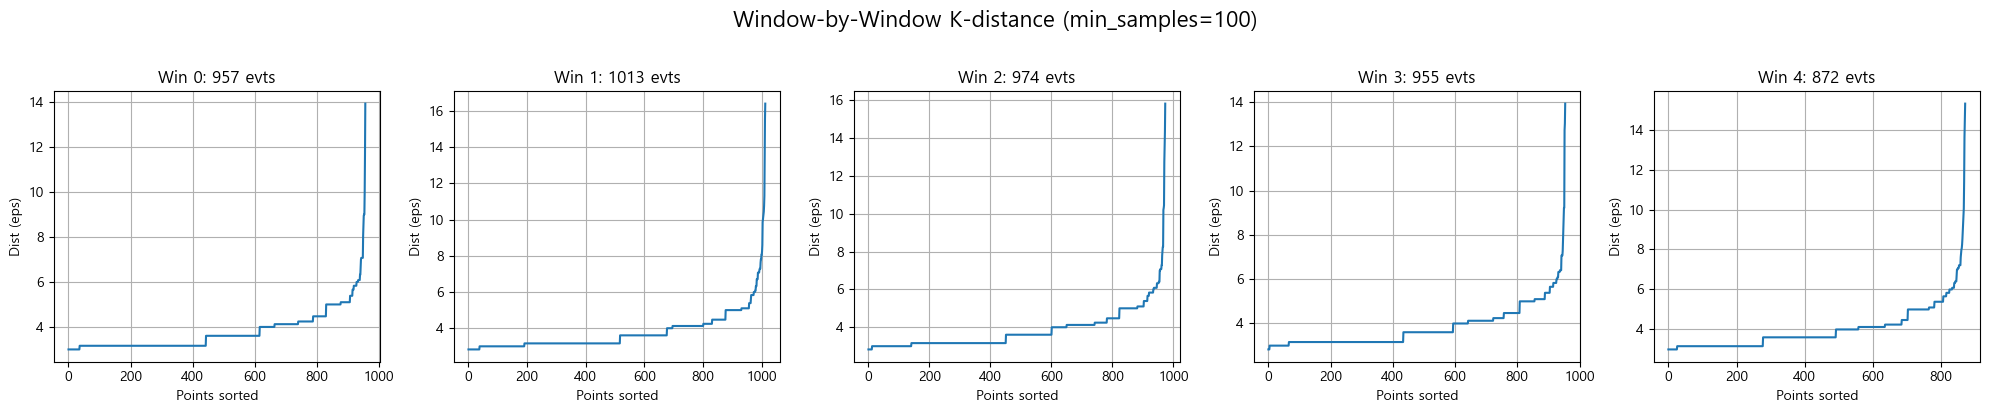

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import math
import platform
import torch
import slayerSNN as snn

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# 데이터 추출 및 Reshape 함수
def get_events_from_index(dataset, index):
    try:
        sample = dataset[index]
        if len(sample) == 3: input_tensor, target, label = sample
        else: input_tensor, label = sample
        
        # 레이블 값 추출
        if isinstance(label, torch.Tensor):
            label_val = int(label.item()) if label.numel() == 1 else int(torch.argmax(label).item())
        else:
            label_val = int(label)
            
        if input_tensor.shape[0] == 2312:
            reshaped_tensor = input_tensor.reshape(2, 34, 34, -1)
            print(f"  [정보] 텐서 Reshape 완료: {input_tensor.shape} -> {reshaped_tensor.shape}")
            spike_data = reshaped_tensor.cpu().numpy()
        else:
            spike_data = input_tensor.cpu().numpy()
        
        event_obj = snn.io.spikeArrayToEvent(spike_data)
        event_data = np.stack([event_obj.x, event_obj.y, event_obj.t], axis=1)
        
        print(f"  [로드 완료] 인덱스 {index} (레이블: {label_val}) - 총 {event_data.shape[0]}개 이벤트")
        
        print(f"   -> X범위: {event_data[:,0].min()}~{event_data[:,0].max()}, Y범위: {event_data[:,1].min()}~{event_data[:,1].max()}")
        
        return event_data, label_val
    except Exception as e:
        print(f"  [오류] 데이터 로드 실패: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 윈도우별 K-distance 그래프 함수
def visualize_windowed_k_distance(event_data, min_samples_list, total_time_step, window_size_step):
    if event_data is None: return

    # 윈도우 분할
    windows = []
    for t_start in range(0, total_time_step, window_size_step):
        t_end = t_start + window_size_step
        mask = (event_data[:, 2] >= t_start) & (event_data[:, 2] < t_end)
        windows.append(event_data[mask])
    
    num_windows = len(windows)
    print(f"  [정보] 총 {num_windows}개의 윈도우로 분할했습니다.")

    # 그래프 그리기
    for min_samples in min_samples_list:
        n_cols = 5
        n_rows = math.ceil(num_windows / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
        axes = axes.flatten()
        
        fig.suptitle(f"Window-by-Window K-distance (min_samples={min_samples})", fontsize=16, y=1.02)

        for i, window_events in enumerate(windows):
            ax = axes[i]
            
            if window_events.shape[0] > 0:
                points = window_events[:, :2] # (x, y) 좌표
                
                if points.shape[0] < min_samples:
                    ax.set_title(f"Win {i}: Too few evts")
                    ax.set_xticks([]); ax.set_yticks([])
                    continue
                
                nbrs = NearestNeighbors(n_neighbors=min_samples).fit(points)
                distances, _ = nbrs.kneighbors(points)
                k_distances = np.sort(distances[:, min_samples-1])
                
                ax.plot(k_distances)
                ax.set_title(f"Win {i}: {points.shape[0]} evts")
                ax.set_xlabel("Points sorted")
                ax.set_ylabel("Dist (eps)")
                ax.grid(True)
            else:
                ax.set_title(f"Win {i}: Empty")
                ax.set_xticks([]); ax.set_yticks([])

        for i in range(num_windows, len(axes)): axes[i].axis('off')
        plt.tight_layout()
        plt.show()

# 실행
INDEX_TO_ANALYZE = 1
MIN_SAMPLES_OPTIONS = [100] # N-MNIST는 이벤트가 적으므로 작은 값 추천
TOTAL_TIME = 260
WINDOW_SIZE = 52

print(f"--- 인덱스 {INDEX_TO_ANALYZE} 데이터 분석 (Reshape 적용) ---")

try:
    event_data, label = get_events_from_index(testingSet, INDEX_TO_ANALYZE)
    if event_data is not None:
        visualize_windowed_k_distance(event_data, MIN_SAMPLES_OPTIONS, TOTAL_TIME, WINDOW_SIZE)
except NameError:
    print("\n[오류] 'testingSet' 변수를 찾을 수 없습니다.")

In [23]:
# 3가지 pkl 파일을 저장

import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import shutil
import math
import pandas as pd

# DBSCAN 함수
def apply_dbscan_and_get_densities(events, eps=5, min_samples=100):
    if events.shape[0] < min_samples:
        return np.empty((0, 4)), [] 
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_
    non_noise_mask = (labels != -1)
    denoised_events = events[non_noise_mask]
    unique_labels = np.unique(labels[non_noise_mask])
    densities = [] 
    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        num_events = len(current_cluster) 
        if num_events > 0:
            locations = current_cluster[:, :2]
            area = pd.DataFrame(locations).drop_duplicates().shape[0]
            density = num_events / area if area > 0 else float('inf')
            densities.append(density)
    return denoised_events, densities

# 시간 창 분할 함수
def process_windows(event_data, total_time_ms=260, window_size_ms=52, stride_ms=52):
    all_clustered_events = []
    n_windows = math.ceil(total_time_ms / stride_ms)
    window_densities_dict = {i: [] for i in range(n_windows)} 
    for i, t_start in enumerate(range(0, total_time_ms, stride_ms)):
        t_end = t_start + window_size_ms
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        window_events = event_data[time_mask]
        if window_events.shape[0] > 0:
            clustered_events, densities = apply_dbscan_and_get_densities(window_events, eps=5, min_samples=100)
            if clustered_events.shape[0] > 0:
                all_clustered_events.append(clustered_events)
            if densities:
                window_densities_dict[i].extend(densities)
    final_events = np.concatenate(all_clustered_events, axis=0) if all_clustered_events else np.empty((0, 4))
    final_densities = window_densities_dict
    return final_events, final_densities

# 메인 전처리 로직
input_folder = 'Train_npy_fin/' 
output_folder = 'train_cluster_window5_5_100_fin/'
sample_list_file = os.path.join(input_folder, 'train.txt')

# 파일 이름 설정
OUTPUT_PKL_FILENAME = 'train_cluster_window5_5_100_fin_stats.pkl' # 기존 통계
OUTPUT_DENSITY_LIST_PKL = 'nmnist_train_densities_fin.pkl'  # 원본 리스트
OUTPUT_PERCENTILES_PKL = 'nmnist_train_percentiles_fin.pkl'  # 핵심 백분위수

TOTAL_TIME_MS = 260
WINDOW_SIZE_MS = 52
STRIDE_MS = 52
N_WINDOWS = math.ceil(TOTAL_TIME_MS / STRIDE_MS)
NUM_CLASSES = 10

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더를 생성했습니다.")

all_label_window_densities = {
    label: {win_idx: [] for win_idx in range(N_WINDOWS)} for label in range(NUM_CLASSES)
}

try:
    label_map = {int(index): int(label) for index, label in np.loadtxt(sample_list_file)}
    existing_indices = {int(f.split('.')[0]) for f in os.listdir(input_folder) if f.endswith('.npy')}
    samples_to_process = [[idx, label_map[idx]] for idx in sorted(list(existing_indices)) if idx in label_map]
    output_list_file = os.path.join(output_folder, 'train.txt')
    np.savetxt(output_list_file, samples_to_process, fmt='%d')
    print(f"실제로 '{input_folder}' 폴더에 존재하는 {len(samples_to_process)}개의 파일만 처리합니다.")
except (FileNotFoundError, ValueError):
    print(f"오류: '{sample_list_file}' 또는 '{input_folder}' 경로를 확인해주세요.")
    samples_to_process = [] 

for sample_info in tqdm(samples_to_process, desc="N-MNIST 클러스터링 진행률"):
    file_index = sample_info[0]
    label = sample_info[1] 
    input_file_path = os.path.join(input_folder, f'{file_index}.npy')
    output_file_path = os.path.join(output_folder, f'{file_index}.npy')
    try:
        event_data = np.load(input_file_path, allow_pickle=True)
        if not (event_data.ndim == 2 and event_data.shape[1] == 4): event_data = np.empty((0, 4))
    except: event_data = np.empty((0, 4))

    if event_data.shape[0] > 0:
        filtered_events = event_data[event_data[:, 3] < TOTAL_TIME_MS]
    else: filtered_events = np.empty((0, 4))

    if filtered_events.shape[0] > 0:
        denoised_events, window_densities = process_windows(filtered_events, TOTAL_TIME_MS, WINDOW_SIZE_MS, STRIDE_MS)
        for window_idx, densities in window_densities.items():
            if densities:
                all_label_window_densities[label][window_idx].extend(densities)
    else: denoised_events = np.empty((0, 4))

    np.save(output_file_path, denoised_events)

print(f"\n모든 파일 처리가 완료되었습니다.")


# 통계 및 파일 저장
print(f"\n통계 파일들을 저장합니다...")

final_stats_summary = {label: {} for label in range(NUM_CLASSES)}
final_percentiles_summary = {label: {} for label in range(NUM_CLASSES)} 

for label_id, window_data in all_label_window_densities.items():
    for window_idx, densities in window_data.items():
        if densities: 
            densities_arr = np.array(densities)
            
            # 기본 통계
            stats_dict = {
                '총 클러스터 수': len(densities_arr),
                '평균 밀도': np.mean(densities_arr),
                '표준 편차': np.std(densities_arr),
                '최소 밀도': np.min(densities_arr),
                '최대 밀도': np.max(densities_arr),
                '99% 백분위수': np.percentile(densities_arr, 99)
            }
            
            # 백분위수 및 IQR 상한선 계산
            q1 = np.percentile(densities_arr, 25)
            q3 = np.percentile(densities_arr, 75)
            iqr = q3 - q1
            iqr_fence = q3 + (1.5 * iqr) # 이상치 상한 경계
            
            percentiles_dict = {
                'p50': np.percentile(densities_arr, 50), # 중앙값
                'p75': q3,
                'p99': np.percentile(densities_arr, 99),
                'p100': np.max(densities_arr),
                'iqr_fence': iqr_fence
            }
            # ----------------------------------------------------------
        else: 
            stats_dict = {'총 클러스터 수': 0, '평균 밀도': 0, '표준 편차': 0, '최소 밀도': 0, '최대 밀도': 0, '99% 백분위수': 0}
            percentiles_dict = {'p50': 0, 'p75': 0, 'p99': 0, 'p100': 0, 'iqr_fence': 0}
        
        final_stats_summary[label_id][window_idx] = stats_dict
        final_percentiles_summary[label_id][window_idx] = percentiles_dict

try:
    with open(OUTPUT_PKL_FILENAME, 'wb') as f:
        pickle.dump(final_stats_summary, f)
    print(f"[✅] 통계 요약 정보: '{OUTPUT_PKL_FILENAME}' 저장됨.")
except Exception as e: print(f"[❌] 오류: {e}")

try:
    with open(OUTPUT_DENSITY_LIST_PKL, 'wb') as f:
        pickle.dump(all_label_window_densities, f)
    print(f"[✅] 원본 밀도 리스트: '{OUTPUT_DENSITY_LIST_PKL}' 저장됨.")
except Exception as e: print(f"[❌] 오류: {e}")

try:
    with open(OUTPUT_PERCENTILES_PKL, 'wb') as f:
        pickle.dump(final_percentiles_summary, f)
    print(f"[✅] 백분위수 요약 정보: '{OUTPUT_PERCENTILES_PKL}' 저장됨.")
except Exception as e: print(f"[❌] 오류: {e}")

'train_cluster_window5_5_100_fin/' 폴더를 생성했습니다.
실제로 'Train_npy_fin/' 폴더에 존재하는 59999개의 파일만 처리합니다.


N-MNIST 클러스터링 진행률: 100%|███████████████████████████████████████████████| 59999/59999 [2:50:42<00:00,  5.86it/s]


모든 파일 처리가 완료되었습니다.

통계 파일들을 저장합니다...
[✅] 통계 요약 정보: 'train_cluster_window5_5_100_fin_stats.pkl' 저장됨.
[✅] 원본 밀도 리스트: 'nmnist_train_densities_fin.pkl' 저장됨.
[✅] 백분위수 요약 정보: 'nmnist_train_percentiles_fin.pkl' 저장됨.


--- 'nmnist_train_densities_fin.pkl' 데이터 로드 성공 ---

       [ 클러스터 밀도 통계 요약 ]
 1. 총 클러스터 수 :  300,058
 2. 평균 밀도      :  2.6103
 3. 표준 편차      :  0.2724
 4. 최소 밀도      :  1.5081
 5. 최대 밀도      :  3.5430
 6. 99% 백분위수   :  3.1299


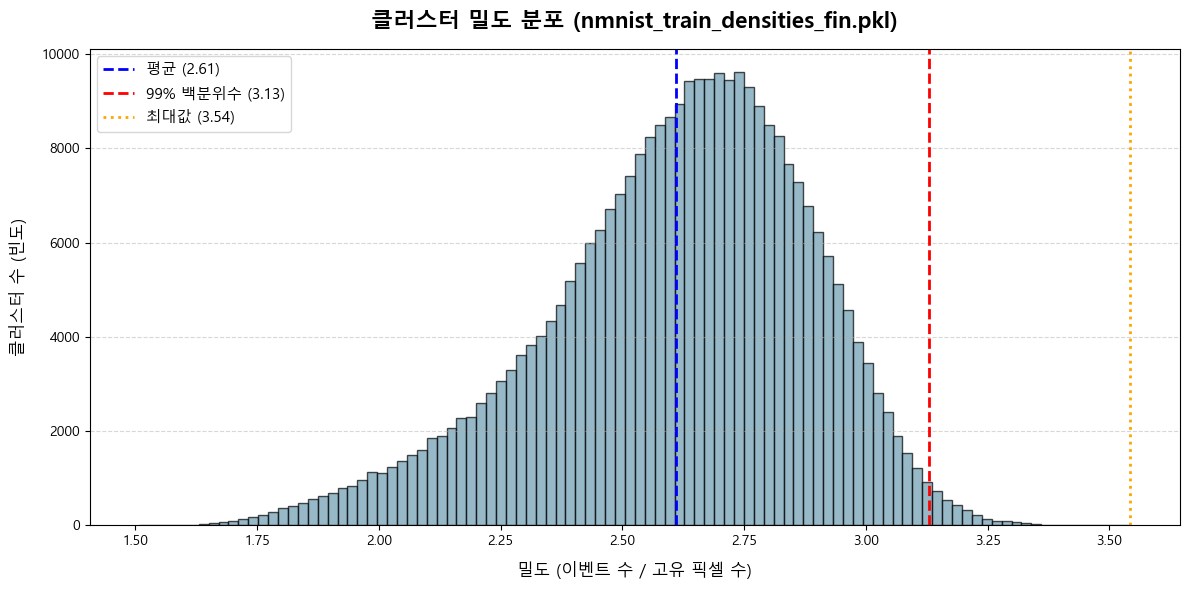

In [25]:
# 2가지 자료를 뽑음
# 1. pkl 파일의 통계 출력 (밀도 지표 비교 표 만들기 위함)
# 2. pkl 파일의 밀도 분포를 그래프로 그림

import pickle
import numpy as np
import matplotlib.pyplot as plt
import platform
import os

# 1. 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

def analyze_and_visualize_densities(pkl_filename):
    
    # 데이터 로드 및 통합
    try:
        with open(pkl_filename, 'rb') as f:
            # 구조: { label_id: { window_idx: [density1, density2...] } } 
            # 또는 { label_id: [density1, density2...] }
            raw_data = pickle.load(f)
        print(f"--- '{pkl_filename}' 데이터 로드 성공 ---")
    except FileNotFoundError:
        print(f"오류: '{pkl_filename}' 파일을 찾을 수 없습니다.")
        return

    # 모든 레이블, 모든 윈도우의 밀도 값을 하나로 합침
    all_densities = []
    
    # 딕셔너리 구조에 따라 유연하게 처리
    for key, value in raw_data.items():
        if isinstance(value, dict): # 윈도우별로 나뉘어 있는 경우
            for window_densities in value.values():
                all_densities.extend(window_densities)
        elif isinstance(value, list): # 레이블별로 리스트인 경우
            all_densities.extend(value)

    if not all_densities:
        print("데이터가 비어있어 분석할 수 없습니다.")
        return

    densities_arr = np.array(all_densities)

    # 6가지 핵심 통계 지표 계산
    total_count = len(densities_arr)
    mean_val = np.mean(densities_arr)
    std_val = np.std(densities_arr)
    min_val = np.min(densities_arr)
    max_val = np.max(densities_arr)
    percentile_99 = np.percentile(densities_arr, 99)

    # 통계 출력
    print("\n" + "="*40)
    print("       [ 클러스터 밀도 통계 요약 ]")
    print("="*40)
    print(f" 1. 총 클러스터 수 :  {total_count:,}")
    print(f" 2. 평균 밀도      :  {mean_val:.4f}")
    print(f" 3. 표준 편차      :  {std_val:.4f}")
    print(f" 4. 최소 밀도      :  {min_val:.4f}")
    print(f" 5. 최대 밀도      :  {max_val:.4f}")
    print(f" 6. 99% 백분위수   :  {percentile_99:.4f}")
    print("="*40)

    # 밀도 분포 히스토그램 시각화
    plt.figure(figsize=(12, 6))
    
    # 히스토그램 그리기
    n, bins, patches = plt.hist(densities_arr, bins=100, color='#6A9AB0', edgecolor='black', alpha=0.7)
    
    # 주요 통계선 표시
    plt.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'평균 ({mean_val:.2f})')
    plt.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99% 백분위수 ({percentile_99:.2f})')
    plt.axvline(max_val, color='orange', linestyle=':', linewidth=2, label=f'최대값 ({max_val:.2f})')

    # 그래프 꾸미기
    plt.title(f"클러스터 밀도 분포 ({pkl_filename})", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("밀도 (이벤트 수 / 고유 픽셀 수)", fontsize=12, labelpad=10)
    plt.ylabel("클러스터 수 (빈도)", fontsize=12, labelpad=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.legend(fontsize=11)
    
    # 로그 스케일 옵션 (값 차이가 클 경우 주석 해제하여 사용)
    plt.tight_layout()
    plt.show()

# 실행
TARGET_FILE = 'nmnist_train_densities_fin.pkl' 

analyze_and_visualize_densities(TARGET_FILE)

In [9]:
import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import pandas as pd
import shutil

# 정 및 통계 파일 로드

STATS_PKL_PATH = 'nmnist_train_percentiles_fin.pkl'
INPUT_FOLDER = 'mfawaredashattack_fin_ps50/'       # 공격 데이터 폴더
BASE_OUTPUT_FOLDER = 'mfawaredashattack_ps50_cluster_window5_5_100_fin' # 결과 저장 기본 폴더명

# N-MNIST 데이터 시간 설정
TOTAL_TIME_MS = 260
WINDOW_SIZE_MS = 52
STRIDE_MS = 52

# 훈련 코드에서 저장한 키 이름과 일치시킴
METRICS_KEYS = [
    'p50',       # 50% 백분위수 (중앙값)
    'p75',       # 75% 백분위수
    'p99',       # 99% 백분위수
    'p100',      # 최대값
    'iqr_fence'  # 이상치 상한 경계 (Q3 + 1.5 * IQR)
]

# 결과 폴더
FOLDER_SUFFIXES = {
    'p50': '50pct',
    'p75': '75pct',
    'p99': '99pct',
    'p100': '100pct',
    'iqr_fence': 'IQR'
}

# 임계값 저장소
THRESHOLDS = {} 

print(f"--- [1] 통계 파일 로드: {STATS_PKL_PATH} ---")
try:
    with open(STATS_PKL_PATH, 'rb') as f:
        train_stats_summary = pickle.load(f)

    # 모든 윈도우, 모든 라벨의 통계치를 수집
    collected_values = {key: [] for key in METRICS_KEYS}

    # 중첩 구조 순회 (Label -> Window Index -> Stats Dictionary)
    for label_data in train_stats_summary.values():
        for window_stats in label_data.values():
            if window_stats.get('p100', 0) > 0:
                for key in METRICS_KEYS:
                    if key in window_stats:
                        collected_values[key].append(window_stats[key])

    # 각 지표별 전역 최대값 추출
    print("--- [2] 임계값 설정 완료 ---")
    for key in METRICS_KEYS:
        if collected_values[key]:
            # 가장 보수적인 기준(가장 높은 밀도)을 임계값으로 사용
            max_val = np.max(collected_values[key])
            THRESHOLDS[key] = max_val
            suffix = FOLDER_SUFFIXES[key]
            print(f"  > {key} ({suffix}): {max_val:.4f}")
        else:
            THRESHOLDS[key] = float('inf')
            print(f"  ! 경고: {key} 데이터가 없어 임계값을 무한대로 설정합니다.")

except FileNotFoundError:
    print(f"오류: '{STATS_PKL_PATH}' 파일을 찾을 수 없습니다.")
    exit()
except Exception as e:
    print(f"통계 로드 중 오류: {e}")
    exit()

# 출력 디렉토리 생성
output_dirs = {}
for key, suffix in FOLDER_SUFFIXES.items():
    dir_name = f"{BASE_OUTPUT_FOLDER}_{suffix}"
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    output_dirs[key] = dir_name

# DBSCAN 및 다중 필터링 함수

def process_window_multi_threshold(events, thresholds_dict, eps=5, min_samples=100):
    # 결과 담을 딕셔너리 초기화
    results = {key: [] for key in thresholds_dict.keys()}

    if events.shape[0] < min_samples:
        return results # 빈 결과 반환

    # DBSCAN 실행
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_
    unique_labels = np.unique(labels[labels != -1])

    if unique_labels.size == 0:
        return results

    # 클러스터별 밀도 확인
    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        
        # 밀도 계산
        locations = current_cluster[:, :2]
        unique_pixels = pd.DataFrame(locations).drop_duplicates().shape[0]
        num_events = len(current_cluster)
        
        density = num_events / unique_pixels if unique_pixels > 0 else 0

        for key, threshold in thresholds_dict.items():
            if density <= threshold:
                results[key].append(current_cluster)

    # 리스트를 numpy 배열로 변환
    final_arrays = {}
    for key, cluster_list in results.items():
        if cluster_list:
            final_arrays[key] = np.concatenate(cluster_list, axis=0)
        else:
            final_arrays[key] = np.empty((0, 4))
            
    return final_arrays

# 메인 처리 로직

# 파일 리스트 준비
sample_list_file = os.path.join(INPUT_FOLDER, 'test.txt')
try:
    # test.txt 읽기
    label_map = {int(idx): int(lbl) for idx, lbl in np.loadtxt(sample_list_file)}
    
    # 실제 폴더에 있는 파일만 필터링
    existing_files = {int(f.split('.')[0]) for f in os.listdir(INPUT_FOLDER) if f.endswith('.npy')}
    target_indices = sorted(list(existing_files.intersection(label_map.keys())))
    
    samples_to_process = [[idx, label_map[idx]] for idx in target_indices]
    
    # 각 결과 폴더에도 test.txt 복사
    for folder in output_dirs.values():
        np.savetxt(os.path.join(folder, 'test.txt'), samples_to_process, fmt='%d')

    print(f"--- [3] 총 {len(samples_to_process)}개 파일 처리를 시작합니다. ---")

except Exception as e:
    print(f"파일 리스트 준비 실패: {e}")
    exit()

# 메인 루프
for sample_info in tqdm(samples_to_process, desc="Filtering Progress"):
    file_idx, label = sample_info
    input_path = os.path.join(INPUT_FOLDER, f"{file_idx}.npy")
    
    try:
        raw_events = np.load(input_path, allow_pickle=True)
    except:
        raw_events = np.empty((0, 4))

    if raw_events.shape[0] > 0:
        raw_events = raw_events[raw_events[:, 3] < TOTAL_TIME_MS]
    else:
        raw_events = np.empty((0, 4))

    # 윈도우별 결과를 모을 리스트
    file_aggregated_results = {key: [] for key in METRICS_KEYS}

    if raw_events.shape[0] > 0:
        for t_start in range(0, TOTAL_TIME_MS, STRIDE_MS):
            t_end = t_start + WINDOW_SIZE_MS
            mask = (raw_events[:, 3] >= t_start) & (raw_events[:, 3] < t_end)
            win_events = raw_events[mask]

            if win_events.shape[0] > 0:
                window_outputs = process_window_multi_threshold(
                    win_events, 
                    THRESHOLDS, 
                    eps=2,           
                    min_samples=10   
                )
                
                for key in METRICS_KEYS:
                    # 안전장치: 혹시라도 리스트로 반환되었을 경우 대비
                    data = window_outputs[key]
                    if isinstance(data, list): 
                        if len(data) > 0: data = np.concatenate(data, axis=0)
                        else: data = np.empty((0, 4))

                    if data.shape[0] > 0:
                        file_aggregated_results[key].append(data)

    # 최종 저장
    for key in METRICS_KEYS:
        save_folder = output_dirs[key]
        save_path = os.path.join(save_folder, f"{file_idx}.npy")
        
        if file_aggregated_results[key]:
            final_data = np.concatenate(file_aggregated_results[key], axis=0)
        else:
            final_data = np.empty((0, 4))
            
        np.save(save_path, final_data)

print("\n=== 모든 처리가 완료되었습니다 ===")
for key, folder in output_dirs.items():
    print(f"[{key}] 기준 필터링 결과 -> {folder}")

--- [1] 통계 파일 로드: nmnist_train_percentiles_fin.pkl ---
--- [2] 임계값(Global Max) 설정 완료 ---
  > p50 (50pct): 2.8471
  > p75 (75pct): 3.0026
  > p99 (99pct): 3.2796
  > p100 (100pct): 3.5430
  > iqr_fence (IQR): 3.5660
--- [3] 총 9999개 파일 처리를 시작합니다. ---


Filtering Progress: 100%|██████████████████████████████████████████████████████████| 9999/9999 [29:43<00:00,  5.61it/s]


=== 모든 처리가 완료되었습니다 ===
[p50] 기준 필터링 결과 -> mfawaredashattack_ps50_cluster_window5_5_100_fin_50pct
[p75] 기준 필터링 결과 -> mfawaredashattack_ps50_cluster_window5_5_100_fin_75pct
[p99] 기준 필터링 결과 -> mfawaredashattack_ps50_cluster_window5_5_100_fin_99pct
[p100] 기준 필터링 결과 -> mfawaredashattack_ps50_cluster_window5_5_100_fin_100pct
[iqr_fence] 기준 필터링 결과 -> mfawaredashattack_ps50_cluster_window5_5_100_fin_IQR


In [ ]:
# test data에 대해서는 밀도 통계와 분포만 뽑음

import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import shutil
import math
import pandas as pd 

# DBSCAN 함수
def apply_dbscan_and_get_densities(events, eps=5, min_samples=100):
    if events.shape[0] < min_samples: return np.empty((0, 4)), [] 
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_
    non_noise_mask = (labels != -1)
    denoised_events = events[non_noise_mask]
    unique_labels = np.unique(labels[non_noise_mask])
    densities = [] 
    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        num_events = len(current_cluster) 
        if num_events > 0:
            locations = current_cluster[:, :2]
            area = pd.DataFrame(locations).drop_duplicates().shape[0]
            density = num_events / area if area > 0 else float('inf')
            densities.append(density)
    return denoised_events, densities

# 시간 창 분할 함수
def process_windows(event_data, total_time_ms=260, window_size_ms=52, stride_ms=52):
    all_clustered_events = []
    n_windows = math.ceil(total_time_ms / stride_ms)
    window_densities_dict = {i: [] for i in range(n_windows)} 
    for i, t_start in enumerate(range(0, total_time_ms, stride_ms)):
        t_end = t_start + window_size_ms
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        window_events = event_data[time_mask]
        if window_events.shape[0] > 0:
            clustered_events, densities = apply_dbscan_and_get_densities(window_events, eps=5, min_samples=100)
            if clustered_events.shape[0] > 0:
                all_clustered_events.append(clustered_events)
            if densities:
                window_densities_dict[i].extend(densities)
    final_events = np.concatenate(all_clustered_events, axis=0) if all_clustered_events else np.empty((0, 4))
    final_densities = window_densities_dict
    return final_events, final_densities

# 메인 전처리 로직
input_folder = 'Test_npy_fin/' 
output_folder = 'test_cluster_window5_5_100_fin/' 
sample_list_file = os.path.join(input_folder, 'train.txt')

OUTPUT_PKL_FILENAME = 'test_cluster_window5_5_100_fin_stats.pkl' # 통계 요약
# 원본 밀도 리스트를 저장할 파일명
OUTPUT_DENSITY_LIST_PKL = 'nmnist_test_densities_fin.pkl'

TOTAL_TIME_MS = 260
WINDOW_SIZE_MS = 52
STRIDE_MS = 52
N_WINDOWS = math.ceil(TOTAL_TIME_MS / STRIDE_MS)

if not os.path.exists(output_folder): os.makedirs(output_folder)

all_label_window_densities = {
    label: {win_idx: [] for win_idx in range(N_WINDOWS)} for label in range(11)
}

try:
    label_map = {int(index): int(label) for index, label in np.loadtxt(sample_list_file)}
    existing_indices = {int(f.split('.')[0]) for f in os.listdir(input_folder) if f.endswith('.npy')}
    samples_to_process = [[idx, label_map[idx]] for idx in sorted(list(existing_indices)) if idx in label_map]
    output_list_file = os.path.join(output_folder, 'train.txt')
    np.savetxt(output_list_file, samples_to_process, fmt='%d')
except (FileNotFoundError, ValueError):
    samples_to_process = [] 

for sample_info in tqdm(samples_to_process, desc="클러스터링 진행률"):
    file_index = sample_info[0]
    label = sample_info[1] 
    input_file_path = os.path.join(input_folder, f'{file_index}.npy')
    output_file_path = os.path.join(output_folder, f'{file_index}.npy')

    try:
        event_data = np.load(input_file_path, allow_pickle=True)
        if not (event_data.ndim == 2 and event_data.shape[1] == 4): event_data = np.empty((0, 4))
    except: event_data = np.empty((0, 4))

    if event_data.shape[0] > 0:
        filtered_events = event_data[event_data[:, 3] < TOTAL_TIME_MS]
    else: filtered_events = np.empty((0, 4))

    if filtered_events.shape[0] > 0:
        denoised_events, window_densities = process_windows(filtered_events, TOTAL_TIME_MS, WINDOW_SIZE_MS, STRIDE_MS)
        for window_idx, densities in window_densities.items():
            if densities:
                all_label_window_densities[label][window_idx].extend(densities)
    else: denoised_events = np.empty((0, 4))

    np.save(output_file_path, denoised_events)

print(f"\n모든 파일 처리 완료.")

# 저장 (통계 요약 + 원본 리스트)
final_stats_summary = {label: {} for label in range(11)}
for label_id, window_data in all_label_window_densities.items():
    for window_idx, densities in window_data.items():
        if densities: 
            densities_arr = np.array(densities)
            stats_dict = {
                '총 클러스터 수': len(densities_arr),
                '평균 밀도': np.mean(densities_arr),
                '표준 편차': np.std(densities_arr),
                '최소 밀도': np.min(densities_arr),
                '최대 밀도': np.max(densities_arr),
                '99% 백분위수': np.percentile(densities_arr, 99)
            }
        else: 
            stats_dict = {'총 클러스터 수': 0, '평균 밀도': 0, '표준 편차': 0, '최소 밀도': 0, '최대 밀도': 0, '99% 백분위수': 0}
        final_stats_summary[label_id][window_idx] = stats_dict

# 통계 요약 저장
try:
    with open(OUTPUT_PKL_FILENAME, 'wb') as f:
        pickle.dump(final_stats_summary, f)
    print(f"[✅] 통계 요약 정보: '{OUTPUT_PKL_FILENAME}' 저장됨.")
except Exception as e: print(f"[❌] 통계 저장 오류: {e}")

# 원본 밀도 리스트 저장
try:
    with open(OUTPUT_DENSITY_LIST_PKL, 'wb') as f:
        pickle.dump(all_label_window_densities, f)
    print(f"[✅] 원본 밀도 리스트: '{OUTPUT_DENSITY_LIST_PKL}' 저장됨.")
except Exception as e: print(f"[❌] 리스트 저장 오류: {e}")

In [38]:
# 5가지 임계값을 불러와 필터링해 5가지 폴더를 만들기

import numpy as np
from sklearn.cluster import DBSCAN
import os
import pickle
from tqdm import tqdm
import shutil
import math
import pandas as pd 

# 불러오기
TRAIN_STATS_PKL = 'train_cluster_window5_5_100.pkl' 
GLOBAL_DENSITY_THRESHOLD = float('inf')  

try:
    with open(TRAIN_STATS_PKL, 'rb') as f:
        train_stats_summary = pickle.load(f)
    
    all_99_percentiles = []
    for label_data in train_stats_summary.values():
        for window_stats in label_data.values():
            if window_stats['총 클러스터 수'] > 0:
                all_99_percentiles.append(window_stats['99% 백분위수'])
    
    if all_99_percentiles:
        GLOBAL_DENSITY_THRESHOLD = np.max(all_99_percentiles)
        print(f"'{TRAIN_STATS_PKL}' 로드 성공.")
        print(f"  > N-MNIST 훈련 데이터의 '전역 99% 백분위수 중 최대값'(임계값) = {GLOBAL_DENSITY_THRESHOLD:.4f}")
    else:
        print(f"경고: '{TRAIN_STATS_PKL}'에 유효한 통계 데이터가 없습니다.")

except FileNotFoundError:
    print(f"오류: 통계 파일 '{TRAIN_STATS_PKL}'을 찾을 수 없습니다. N-MNIST용 통계 분석을 먼저 실행하세요.")
except Exception as e:
    print(f"통계 로딩 중 오류 발생: {e}")

# DBSCAN 함수
# N-MNIST는 해상도가 작으므로 eps와 min_samples를 작게 설정
def apply_dbscan_and_filter_nmnist(events, file_index, window_index, 
                                   eps=5, min_samples=10,
                                   density_threshold=float('inf')):
    if events.shape[0] < min_samples:
        return np.empty((0, 4)) 

    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(events[:, :2])
    labels = db.labels_
    unique_labels = np.unique(labels[labels != -1])
    if unique_labels.size == 0:
        return np.empty((0, 4))

    final_events_list = []
    for label in unique_labels:
        cluster_mask = (labels == label)
        current_cluster = events[cluster_mask]
        num_events = len(current_cluster) 
        
        if num_events > 0:
            locations = current_cluster[:, :2]
            area = pd.DataFrame(locations).drop_duplicates().shape[0] # 고유 픽셀 수
            density = num_events / area if area > 0 else float('inf')
            
            is_high_density = (density > density_threshold)
            
            if is_high_density:
                pass
            else:
                final_events_list.append(current_cluster)

    return np.concatenate(final_events_list, axis=0) if final_events_list else np.empty((0, 4))

# 시간 창 분할 함수
def process_windows_with_global_filter(event_data, file_index, 
                                        global_density_threshold,
                                        total_time_ms=260, window_size_ms=52, stride_ms=52):
    all_clustered_events = []
    for i, t_start in enumerate(range(0, total_time_ms, stride_ms)):
        t_end = t_start + window_size_ms
        time_mask = (event_data[:, 3] >= t_start) & (event_data[:, 3] < t_end) 
        window_events = event_data[time_mask]
        
        if window_events.shape[0] > 0:
            clustered_events = apply_dbscan_and_filter_nmnist(
                window_events,
                file_index=file_index, 
                window_index=i,       
                eps=2,            # 👈 N-MNIST용 파라미터
                min_samples=10,   # 👈 N-MNIST용 파라미터
                density_threshold=global_density_threshold
            )
            if clustered_events.shape[0] > 0:
                all_clustered_events.append(clustered_events)

    return np.concatenate(all_clustered_events, axis=0) if all_clustered_events else np.empty((0, 4))

# 메인 전처리 로직

# 실제 N-MNIST 공격 데이터 폴더
input_folder = 'mfawaredashattack/' 
output_folder = 'mfawaredashattack_cluster_window5_5_100_filtered/'
sample_list_file = os.path.join(input_folder, 'test.txt')

# N-MNIST 시간 설정
TOTAL_TIME_MS = 260
WINDOW_SIZE_MS = 52
STRIDE_MS = 52

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더를 생성했습니다.")

# test.txt 생성/복사
try:
    label_map = {int(index): int(label) for index, label in np.loadtxt(sample_list_file)}
    existing_indices = {int(f.split('.')[0]) for f in os.listdir(input_folder) if f.endswith('.npy')}
    samples_to_process = [[idx, label_map[idx]] for idx in sorted(list(existing_indices)) if idx in label_map]
    output_list_file = os.path.join(output_folder, 'test.txt')
    np.savetxt(output_list_file, samples_to_process, fmt='%d')
    print(f"실제로 '{input_folder}' 폴더에 존재하는 {len(samples_to_process)}개의 파일만 처리합니다.")
except (FileNotFoundError, ValueError):
    print(f"오류: '{sample_list_file}' 또는 '{input_folder}' 경로를 확인해주세요.")
    samples_to_process = [] 

# 메인 루프
for sample_info in tqdm(samples_to_process, desc="N-MNIST 밀도 필터링 진행률"):
    file_index, label = sample_info[0], sample_info[1] 
    input_file_path = os.path.join(input_folder, f'{file_index}.npy')
    output_file_path = os.path.join(output_folder, f'{file_index}.npy')

    try:
        event_data = np.load(input_file_path, allow_pickle=True)
    except: event_data = np.empty((0,4))

    if event_data.shape[0] > 0:
        filtered_events = event_data[event_data[:, 3] < TOTAL_TIME_MS]
    else:
        filtered_events = np.empty((0, 4))

    if filtered_events.shape[0] > 0:
        denoised_events = process_windows_with_global_filter(
            filtered_events,
            file_index=file_index,
            global_density_threshold=GLOBAL_DENSITY_THRESHOLD, # 전역 임계값
            total_time_ms=TOTAL_TIME_MS,
            window_size_ms=WINDOW_SIZE_MS,
            stride_ms=STRIDE_MS
        )
    else:
        denoised_events = np.empty((0, 4))

    np.save(output_file_path, denoised_events)

print(f"\n모든 파일 처리가 완료되었습니다. '{output_folder}'에 필터링된 .npy 파일 저장 완료.")

'train_cluster_window5_5_100.pkl' 로드 성공.
  > N-MNIST 훈련 데이터의 '전역 99% 백분위수 중 최대값'(임계값) = 3.2796
실제로 'mfawaredashattack/' 폴더에 존재하는 9999개의 파일만 처리합니다.


N-MNIST 밀도 필터링 진행률: 100%|██████████████████████████████████████████████████| 9999/9999 [29:28<00:00,  5.65it/s]


모든 파일 처리가 완료되었습니다. 'mfawaredashattack_cluster_window5_5_100_filtered/'에 필터링된 .npy 파일 저장 완료.


In [11]:
# top-k test 0223
topk_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
correct_topk = {k: 0 for k in topk_list}
total_samples = 0
# print(correct_topk)
# testSet = IBMGestureDataset(datasetPath  ='/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/prova_mf_50/', 
#                               sampleFile  ='/home/DVSAttacks/slayerPytorch/exampleLoihi/03_IBMGesture/Test/test.txt',
#                               samplingTime=1.0,
#                               sampleLength=1450)

testSet = nmnistDataset(datasetPath ='N-MNIST/Test/', 
                                sampleFile  ='N-MNIST/Test/test.txt',
                                samplingTime=netParams['simulation']['Ts'],
                                sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testSet, batch_size=1, shuffle=False, num_workers=4)

for epoch in range(1):
    stats.testing.reset()
    tSt = datetime.now()
    # Testing loop.
    for i, (input, target, label) in enumerate(testLoader, 0):
        net.eval()
        with torch.no_grad():
            input  = input.to(device)
            target = target.to(device)
        
        output = net.forward(input)
        
        # t를 따라서 (여기선 4번째 dim)을 따라 spike 수를 합산
        numSpikes = torch.sum(output, 4, keepdim=True).cpu()
        numSpikes = numSpikes.view(numSpikes.size(0), -1)  
        # shape: (batch_size, num_classes)
        print("numSpikes = ",numSpikes)
        
        labels = label.cpu().view(-1, 1)
        print("label = ",labels)
        
        # 각 k 값에 대해 top‑k 예측 및 정답 판별
        for k in topk_list:
            topk_preds = torch.topk(numSpikes, k, dim=1)[1]
            # 각 샘플별로 정답이 top‑k 내에 존재하는지 확인
            correct = topk_preds.eq(labels).sum(dim=1) > 0  
            correct_topk[k] += correct.sum().item()
            
        print(correct_topk)
        total_samples += labels.size(0)

        output_predict = snn.predict.getClass(output)
        print(output_predict)
        stats.testing.correctSamples += torch.sum( output_predict == label ).data.item()
        stats.testing.numSamples     += len(label)
        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        stats.print(epoch, i)

for k in topk_list:
    acc = 100.0 * correct_topk[k] / total_samples
    print(f"Top-{k} accuracy: {acc}%")


numSpikes =  tensor([[ 7.,  8., 13.,  3.,  9., 16., 12., 61., 10., 20.]],
       grad_fn=<ViewBackward0>)
label =  tensor([[7]])
{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1}
tensor([7])

Epoch :          0(i =       0)
None
loss = 0.355                              accuracy = 1                        
numSpikes =  tensor([[10.,  6., 59.,  8., 11.,  6., 23.,  8.,  3., 12.]],
       grad_fn=<ViewBackward0>)
label =  tensor([[2]])
{1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2}
tensor([2])

Epoch :          0(i =       1)
None
loss = 0.3975                             accuracy = 1                        
numSpikes =  tensor([[ 5., 67.,  8., 10.,  6., 10., 12., 13.,  1.,  9.]],
       grad_fn=<ViewBackward0>)
label =  tensor([[1]])
{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3}
tensor([1])

Epoch :          0(i =       2)
None
loss = 0.37                               accuracy = 1                        
numSpikes =  tensor([[82.,  6.,  8.,  4.

/home/jupyter-jsw/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1587, Recall: 0.1418, F1-score: 0.1003
Precision: 0.3436, Recall: 0.3427, F1-score: 0.3143
Precision: 0.5915, Recall: 0.5921, F1-score: 0.5772
Precision: 0.8330, Recall: 0.8220, F1-score: 0.8193
Precision: 0.9313, Recall: 0.9285, F1-score: 0.9289
Precision: 0.9401, Recall: 0.9388, F1-score: 0.9390
Precision: 0.9411, Recall: 0.9399, F1-score: 0.9401
Precision: 0.9411, Recall: 0.9399, F1-score: 0.9401
Precision: 0.9411, Recall: 0.9399, F1-score: 0.9401
Precision: 0.0154, Recall: 0.0101, F1-score: 0.0079
Precision: 0.0009, Recall: 0.0009, F1-score: 0.0008


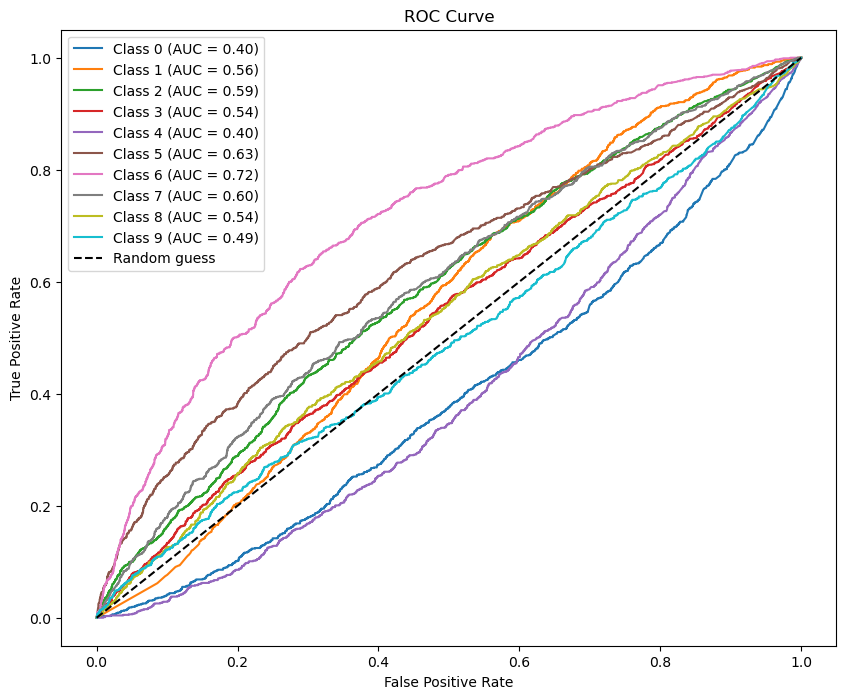

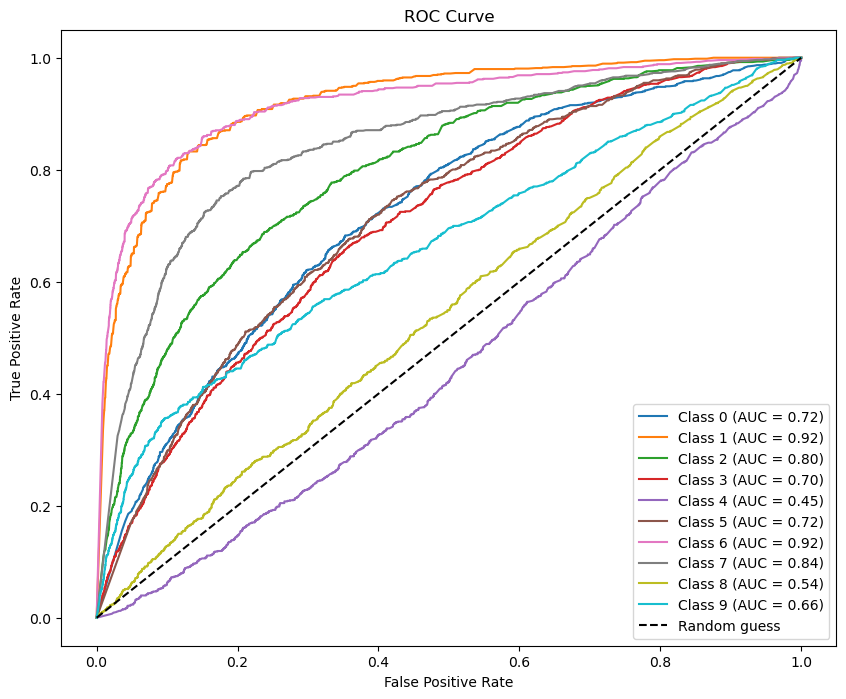

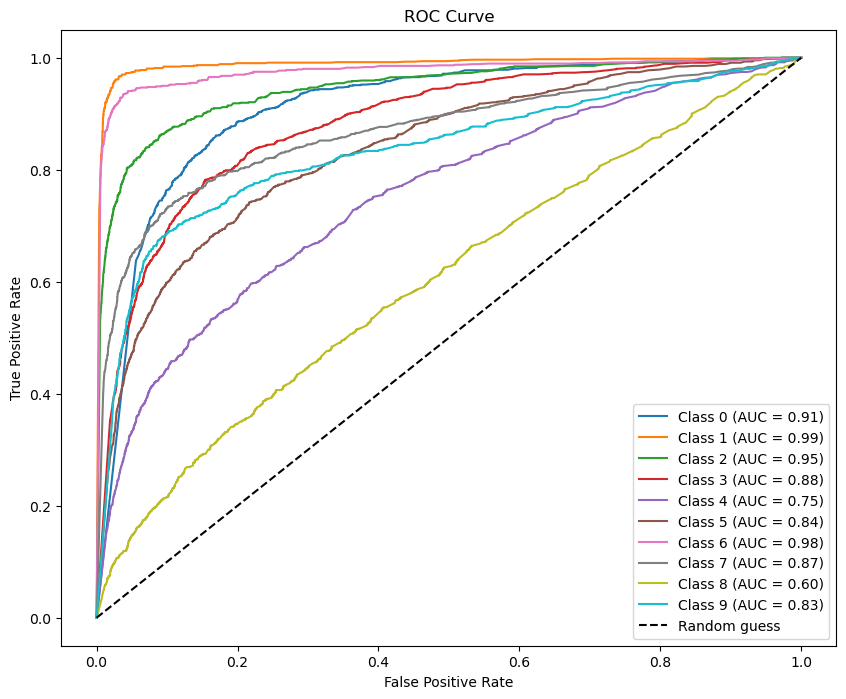

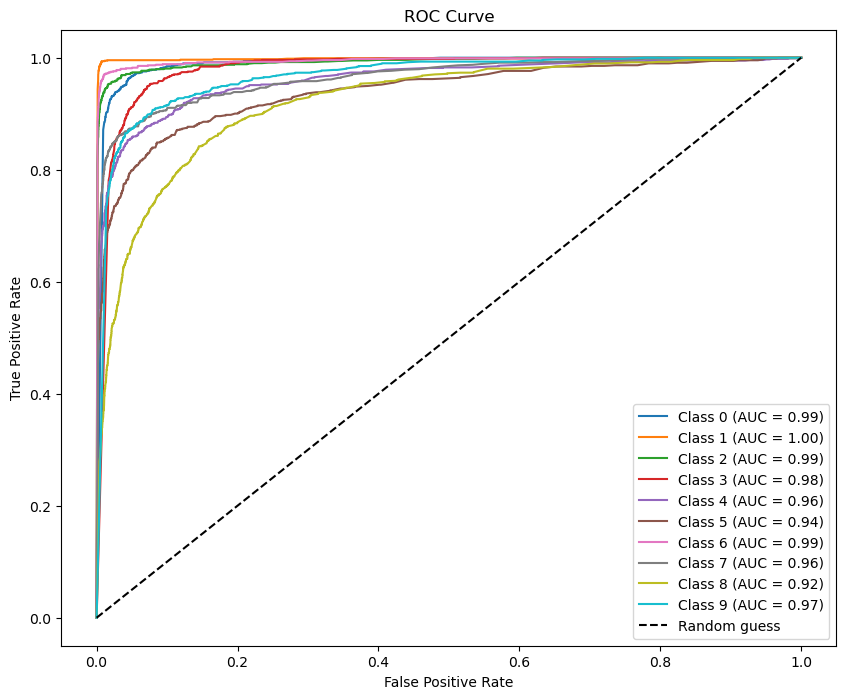

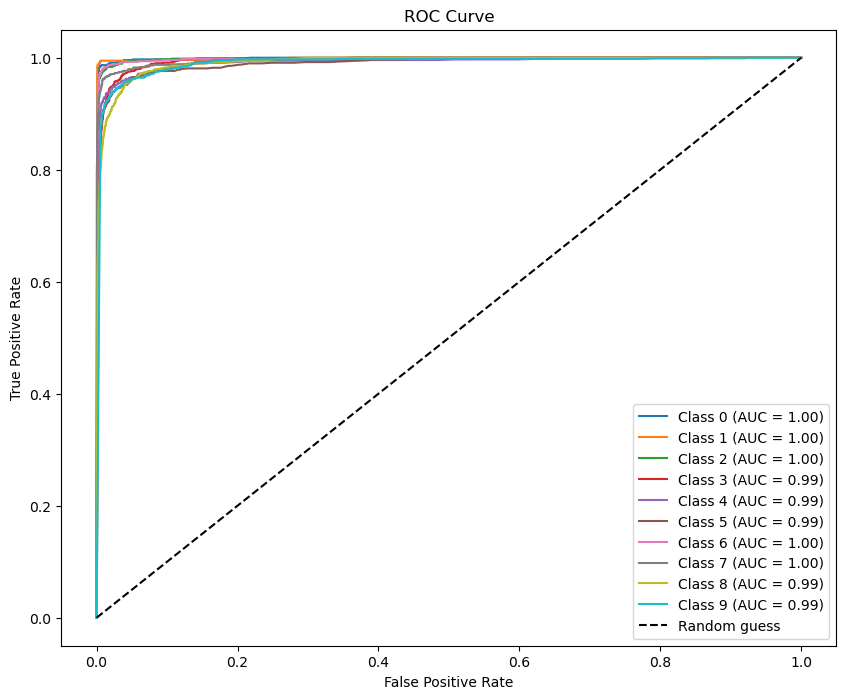

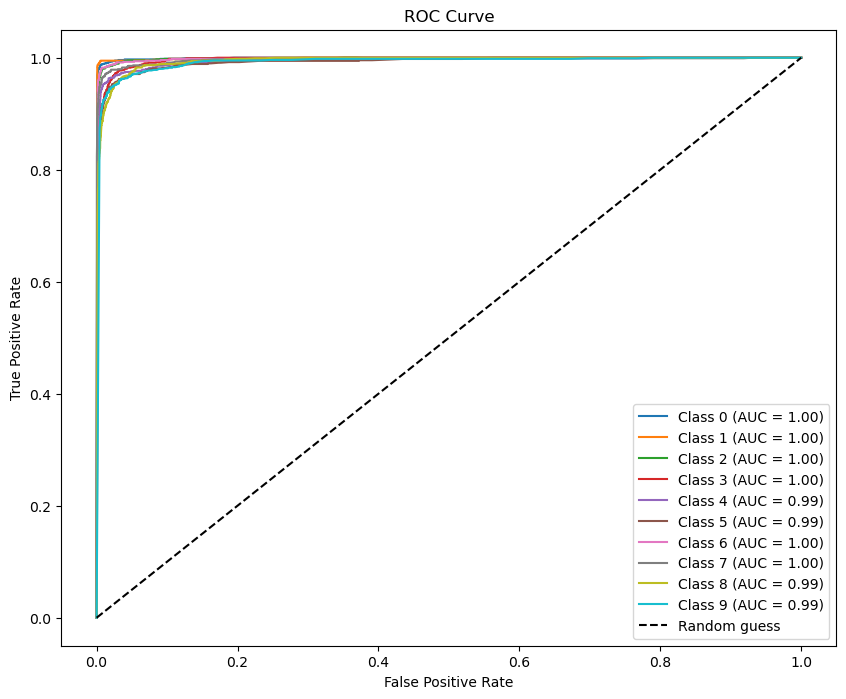

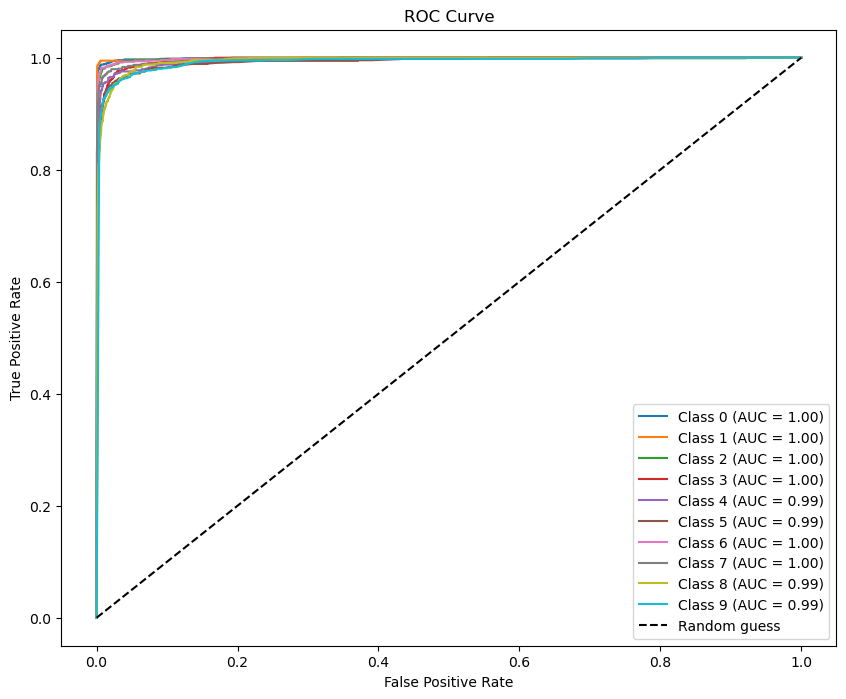

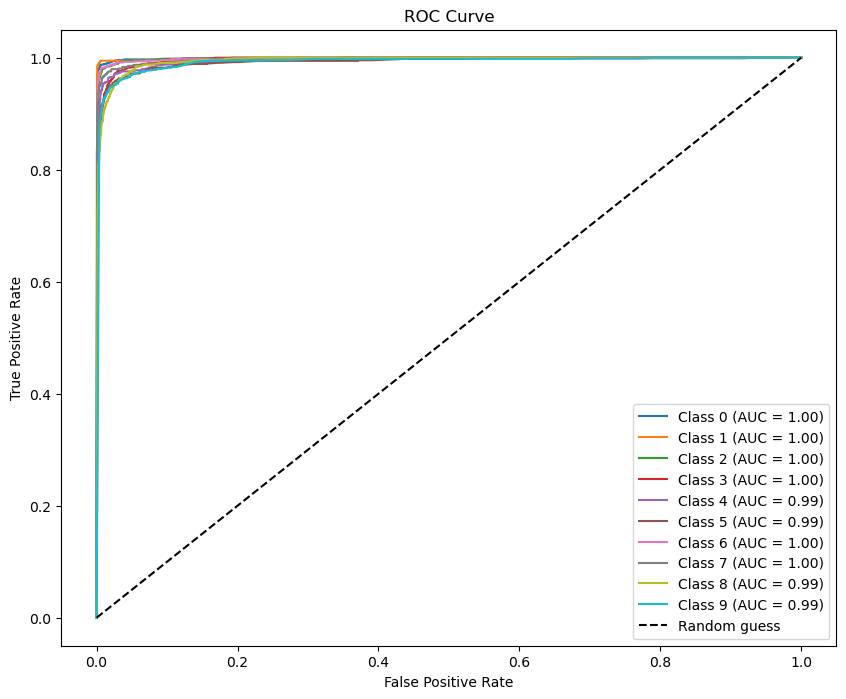

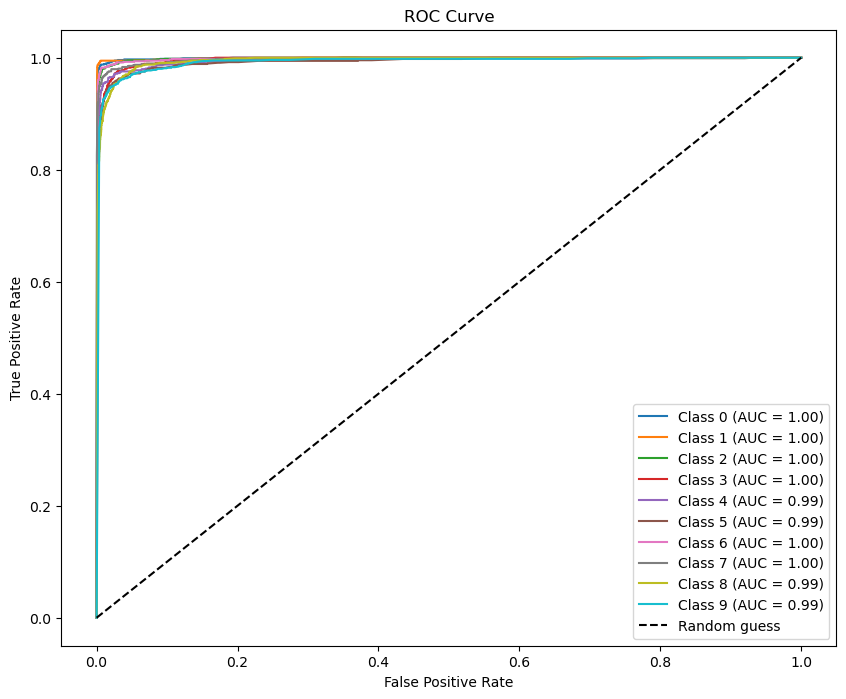

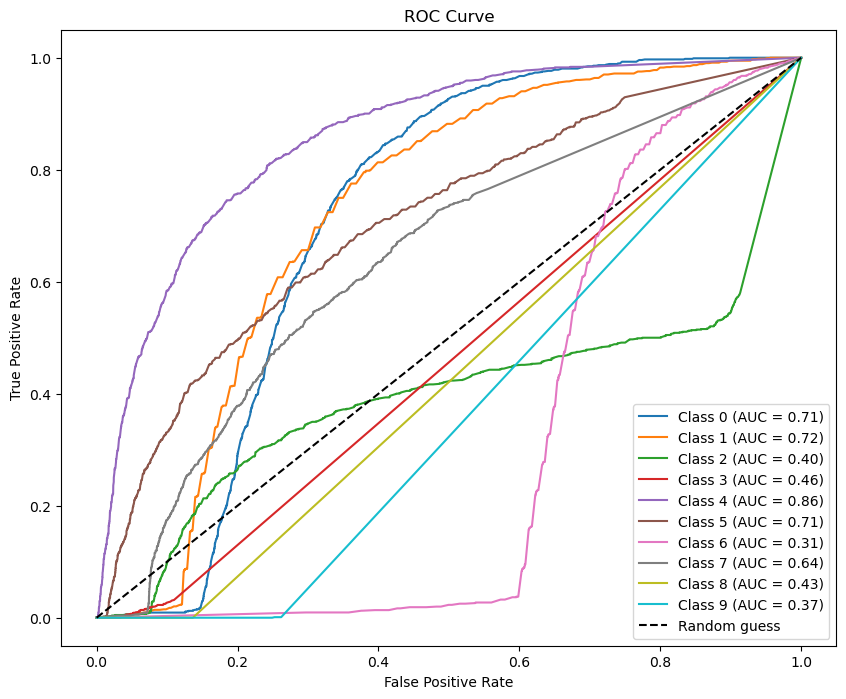

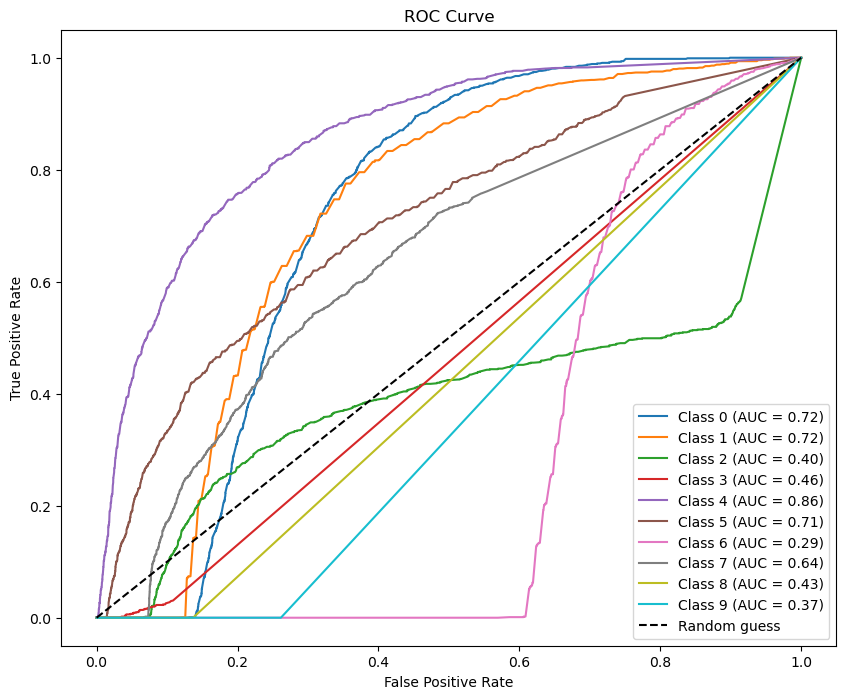

In [13]:
# 두 코드의 차이를 통합하여 수정된 코드(바뀐 완만한 커브)
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader

th = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
for t in th:
    # 테스트 데이터셋 로드
    testingSet = nmnistDataset(
        datasetPath='N-MNIST/mf/{}/'.format(t),
        sampleFile='N-MNIST/Test/test.txt',
        samplingTime=netParams['simulation']['Ts'],
        sampleLength=netParams['simulation']['tSample']
    )
    testLoader = DataLoader(dataset=testingSet, batch_size=40, shuffle=False, num_workers=0)

    # Softmax 함수 정의
    def softmax(x):
        exp_x = np.exp(x - np.max(x))  # 수치 안정성
        return exp_x / exp_x.sum()

    def softmax_for_samples(scores):
        return np.array([softmax(sample) for sample in scores])

    # 평가 시작
    for epoch in range(1):
        stats.testing.reset()
        tSt = datetime.now()
        net.eval()

        y_true = []
        y_pred = []
        y_scores = []

        # Testing loop.
        for i, (input, target, label) in enumerate(testLoader, 0):
            with torch.no_grad():
                input = input.to(device)
                target = target.to(device)

            output = net.forward(input)

            # 모델 예측값 변환
            numSpikes = torch.sum(output, dim=-1).detach().cpu().numpy()
            predicted_classes = snn.predict.getClass(output).detach().cpu().numpy()

            # 데이터 저장
            y_true.extend(label.cpu().numpy())  # 정답 라벨 저장
            y_pred.extend(predicted_classes)  # 예측된 클래스 저장
            y_scores.extend(numSpikes)  # Softmax 적용 전 점수 저장
        
            stats.testing.correctSamples += torch.sum(torch.tensor(predicted_classes) == label.cpu()).data.item()
            stats.testing.numSamples += len(label)

            loss = error.numSpikes(output, target)
            stats.testing.lossSum += loss.cpu().data.item()
            # stats.print(epoch, i)

        # 1️⃣ y_true, y_pred를 numpy 배열로 변환
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # 2️⃣ One-hot encoding 적용 (🚀 클래스 수 10개로 통일)
        y_true = label_binarize(y_true, classes=np.arange(10))

        # 3️⃣ Softmax 적용하여 예측 점수를 확률로 변환
        y_scores = softmax_for_samples(np.array(y_scores))

        # 🚀 4️⃣ 3D → 2D 변환 (두 코드의 차이 해결)
        y_true = np.squeeze(y_true)
        y_scores = np.squeeze(y_scores)

        #print(f"[DEBUG] y_true.shape: {y_true.shape}")
        #print(f"[DEBUG] y_scores.shape: {y_scores.shape}")

        # 5️⃣ Precision, Recall, F1-score 계산
        precision = precision_score(y_true.argmax(axis=1), y_pred, average='macro')
        recall = recall_score(y_true.argmax(axis=1), y_pred, average='macro')
        f1 = f1_score(y_true.argmax(axis=1), y_pred, average='macro')

        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

        # 6️⃣ ROC Curve 계산 및 시각화
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(10):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # 7️⃣ ROC 곡선 시각화
        plt.figure(figsize=(10, 8))
        for i in range(10):
            plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

        plt.plot([0, 1], [0, 1], "k--", label="Random guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="best")
        #plt.show()


# MF-Aware Dash Attack ps=50